In [1]:
import PyPDF2
import stanfordnlp
import pickle
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import *
import random
import math
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(0)

# model and tokenizer class for the concrete downstream task: BertModel, BertForQuestionAnswering, etc.
model_class = BertModel
tokenizer_class = BertTokenizer

# weights to use
pretrained_weights = 'scibert-scivocab-uncased'

# initialize models and tokenizer
bert_model = model_class.from_pretrained(pretrained_weights)
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

# download english models that the neural pipeline will uses
#stanfordnlp.download('en')

# setting a default neural pipeline for english
# Now nlp is a function that receives a string as input and returns an nlp object
MODELS_DIR = '/Users/sergicastellasape/Repos/zeta-alpha/stanfordnlp_resources'
nlp = stanfordnlp.Pipeline(models_dir=MODELS_DIR)

dataset_path = '/Users/sergicastellasape/Repos/zeta-alpha/datasets/dummy/'

def get_attention_vec(model_output):
    input_ids, final_attention, final_state, hidden_states_tup, hidden_attentions_tup = model_output
    hidden_attentions = torch.cat(hidden_attentions_tup, dim=0) # stacking along batch dim
    layers, heads, seq_length, _ = hidden_attentions.size()
    
    # Recover tokens from the first state
    # input_tokens = tokenizer.decode(input_ids)

    # Get attention and reshape at will
    attention_vec = hidden_attentions.view(layers*heads, seq_length, seq_length).transpose(0,2)
    
    # attention_vec is now se
    attention_state_pairs = torch.meshgrid(torch.Tensor(input_ids), torch.Tensor(input_ids))
    state_pairs = torch.stack(attention_state_pairs, dim=0)
    
    #print('SIZES:')
    #print(attention_vec.reshape(seq_length**2, layers*heads).size())
    #print(state_pairs.reshape(seq_length**2, 2).size())
    
    return attention_vec.reshape(seq_length**2, layers*heads), state_pairs.reshape(seq_length**2, 2)


Use device: cpu
---
Loading: tokenize
With settings: 
{'model_path': '/Users/sergicastellasape/Repos/zeta-alpha/stanfordnlp_resources/en_ewt_models/en_ewt_tokenizer.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
---
Loading: pos
With settings: 
{'model_path': '/Users/sergicastellasape/Repos/zeta-alpha/stanfordnlp_resources/en_ewt_models/en_ewt_tagger.pt', 'pretrain_path': '/Users/sergicastellasape/Repos/zeta-alpha/stanfordnlp_resources/en_ewt_models/en_ewt.pretrain.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
---
Loading: lemma
With settings: 
{'model_path': '/Users/sergicastellasape/Repos/zeta-alpha/stanfordnlp_resources/en_ewt_models/en_ewt_lemmatizer.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
Building an attentional Seq2Seq model...
Using a Bi-LSTM encoder
Using soft attention for LSTM.
Finetune all embeddings.
[Running seq2seq lemmatizer with edit classifier]
---
Loading: depparse
With settings: 
{'model_path': '/Users/sergicastellasa

In [7]:
import re
with open("../datasets/quora_questions.txt") as f:
    text = f.read()
    
sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)

try:
    sentences.remove('') # remove possible empty strings
except:
    print('no empty elements found')

no empty elements found


In [8]:
"""input_sequence_list = [
    "Sometimes, all you need to do is completely make an ass of yourself and laugh it off to realise that life isn’t so bad after all.",
    "I was very proud of my nickname throughout high school but today I couldn’t be any different to what my nickname was.",
    "The shooter says goodbye to his love.",
    "A glittering gem is not enough.",
    "I think I will buy the red car, or I will lease the blue one.",
    "If you like tuna and tomato sauce- try combining the two. It’s really not as bad as it sounds.",
    "If you like tuna and tomato sauce- try combining the two. It’s really not as bad as it sounds.",
    "She did not cheat on the test, for it was not the right thing to do.",
    "She folded her handkerchief neatly.",
    "Someone I know recently combined Maple Syrup & buttered Popcorn thinking it would taste like caramel popcorn. It didn’t and they don’t recommend anyone else do it either.",
    "My Mum tries to be cool by saying that she likes all the same things that I do.",
    "Joe made the sugar cookies; Susan decorated them.",
    "I am happy to take your donation; any amount will be greatly appreciated.",
    "I would have gotten the promotion, but my attendance wasn’t good enough.",
    "He turned in the research paper on Friday; otherwise, he would have not passed the class."
]"""

input_sequence_list = sentences

for idx, input_sequence in enumerate(input_sequence_list):
    # generate input in the proper data format
    encoded_inputs_dict = tokenizer.encode_plus(input_sequence)
    
    input_ids = encoded_inputs_dict['input_ids']
    input_tensor = torch.tensor([input_ids])

    # RUN THE MODEL FORWARD
    # the model output consists of a tuple with 4 components which are the following:
    # Final attention: tensor [batch, seq_length, embedding_size]
    # Final state: tensor.Size[batch, embedding_size]
    # hidden_states_tuple: tuple of length # layers + 1 (it probably inclues the input)
        # hidden_states_tuple[i]: tensor.Size(batch, seq_length, embedding_size)
    # hidden_attentions_tuple: tuple of length # layers
        # hidden_attentions_tuple[i]: tensor.Size(batch, #heads, seq_length, seq_length)
    
    model_output = bert_model(input_tensor)
    # add input ids to the tuple to save
    model_output = (input_ids, *model_output)
    
    # generate the stanford nlp object that stores relationships, etc.
    nlp_obj = nlp(input_sequence)
    
    # save in folder for future experiments
    with open(os.path.join(dataset_path, f'scibert_outputs/model_output_{idx}.p'), 'wb' ) as model_file:
        pickle.dump(model_output, model_file)
        
    with open(os.path.join(dataset_path, f'nlp_objects/nlp_obj_{idx}*.p'), 'wb') as nlp_file:
        pickle.dump(nlp_obj, nlp_file)
        

../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATe

../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATe

../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATe

../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATe

../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATe

../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATe

../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATe

../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATe

In [9]:
def attention_dataset_loader(dataset_path, shuffle=True):
    
    model_outputs_list = glob.glob(f'{dataset_path}/scibert_outputs/model_output_*.p')
    nlp_objects_list = glob.glob(f'{dataset_path}/nlp_objects/nlp_obj_*.p')
    data_list = list(zip(model_outputs_list, nlp_objects_list))
    
    attention_dataset = torch.empty((0, 144))
    state_pairs_dataset = torch.empty((0, 2))
    
    for data in data_list:
        with open(data[0], 'rb') as f:
            model_output = pickle.load(f)
        
        input_ids, final_attention, final_state, hidden_states_tup, hidden_attentions_tup = model_output
        attention_vec, state_pairs = get_attention_vec(model_output)
        attention_dataset = torch.cat([attention_dataset, attention_vec] , dim=0)
        state_pairs_dataset = torch.cat([state_pairs_dataset, state_pairs] , dim=0)
        
        with open(data[1], 'rb') as f:
            nlp_obj = pickle.load(f)
    if shuffle:
        idx = torch.randperm(attention_dataset.size(0))
        return attention_dataset[idx, :], state_pairs_dataset[idx, :]
    else:
        return attention_dataset, state_pairs_dataset

In [10]:
data, id_pairs = attention_dataset_loader(dataset_path, shuffle=True)

train_ratio, test_ratio = 0.8, 0.2
N = int(0.8 * data.size(0))

train_data = data[0:N, :]
train_id_pairs = id_pairs[0:N, :]
test_data = data[N:, :]
test_id_pairs = id_pairs[N:, :]

batch_size = 32
train_data_batch = list(train_data.split(batch_size, dim=0))
train_id_pairs_batch = list(train_id_pairs.split(batch_size, dim=0))
test_data_batch = list(test_data.split(batch_size, dim=0))
test_id_pairs = list(test_id_pairs.split(batch_size, dim=0))


        ############ INITIALIZED A VAE ############
        INPUT         (144) -> hidden_layer  (100)
        hidden_layer  (100) -> embedding_mu  (2)
        ------------------------ -> embedding_var (2)
        embedding_mu  (2) -> hidden_layer  (100)
        embedding_var (2) 
        hidden_layer  (100) -> OUTPUT        (144)
        
Attention sample min and max values: 4.073547603251477e-19 | 0.5645349025726318
TOKEN IDS: [2810.0, 214.0]
SAMPLE FROM TOKENS: [supported | by]
Train Epoch: 1 [0/2889 (0%)]	Loss: 1.105870
Train Epoch: 1 [10/2889 (0%)]	Loss: 0.895834
Train Epoch: 1 [20/2889 (1%)]	Loss: 0.736350
Train Epoch: 1 [30/2889 (1%)]	Loss: 0.606827
Train Epoch: 1 [40/2889 (1%)]	Loss: 0.517346
Train Epoch: 1 [50/2889 (2%)]	Loss: 0.454848
Train Epoch: 1 [60/2889 (2%)]	Loss: 0.346914
Train Epoch: 1 [70/2889 (2%)]	Loss: 0.322740
Train Epoch: 1 [80/2889 (3%)]	Loss: 0.317703
Train Epoch: 1 [90/2889 (3%)]	Loss: 0.398097
Train Epoch: 1 [100/2889 (3%)]	Loss: 0.312722
Train Epoch: 1 [11

Train Epoch: 1 [1640/2889 (57%)]	Loss: 0.259476
Train Epoch: 1 [1650/2889 (57%)]	Loss: 0.274445
Train Epoch: 1 [1660/2889 (57%)]	Loss: 0.260426
Train Epoch: 1 [1670/2889 (58%)]	Loss: 0.252514
Train Epoch: 1 [1680/2889 (58%)]	Loss: 0.254198
Train Epoch: 1 [1690/2889 (58%)]	Loss: 0.245299
Train Epoch: 1 [1700/2889 (59%)]	Loss: 0.270020
Train Epoch: 1 [1710/2889 (59%)]	Loss: 0.276563
Train Epoch: 1 [1720/2889 (60%)]	Loss: 0.265351
Train Epoch: 1 [1730/2889 (60%)]	Loss: 0.279319
Train Epoch: 1 [1740/2889 (60%)]	Loss: 0.255595
Train Epoch: 1 [1750/2889 (61%)]	Loss: 0.234525
Train Epoch: 1 [1760/2889 (61%)]	Loss: 0.246768
Train Epoch: 1 [1770/2889 (61%)]	Loss: 0.276434
Train Epoch: 1 [1780/2889 (62%)]	Loss: 0.241326
Train Epoch: 1 [1790/2889 (62%)]	Loss: 0.202763
Train Epoch: 1 [1800/2889 (62%)]	Loss: 0.281914
Train Epoch: 1 [1810/2889 (63%)]	Loss: 0.239723
Train Epoch: 1 [1820/2889 (63%)]	Loss: 0.296596
Train Epoch: 1 [1830/2889 (63%)]	Loss: 0.394568
Train Epoch: 1 [1840/2889 (64%)]	Loss: 0

Train Epoch: 2 [430/2889 (15%)]	Loss: 0.286168
Train Epoch: 2 [440/2889 (15%)]	Loss: 0.281535
Train Epoch: 2 [450/2889 (16%)]	Loss: 0.233710
Train Epoch: 2 [460/2889 (16%)]	Loss: 0.215741
Train Epoch: 2 [470/2889 (16%)]	Loss: 0.297761
Train Epoch: 2 [480/2889 (17%)]	Loss: 0.221259
Train Epoch: 2 [490/2889 (17%)]	Loss: 0.253434
Train Epoch: 2 [500/2889 (17%)]	Loss: 0.255376


KeyboardInterrupt: 

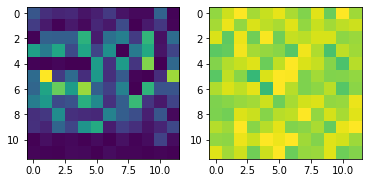

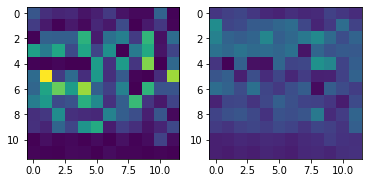

In [17]:
#device = torch.device("cuda" if args.cuda else "cpu")

class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, embedding_size):
        super(VAE, self).__init__()
        self.input_size = input_size
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, embedding_size)
        self.fc22 = nn.Linear(hidden_size, embedding_size)
        self.fc3 = nn.Linear(embedding_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        
        message = f"""
        ############ INITIALIZED A VAE ############
        INPUT         ({input_size }) -> hidden_layer  ({hidden_size})
        hidden_layer  ({hidden_size}) -> embedding_mu  ({embedding_size})
        ------------------------ -> embedding_var ({embedding_size})
        embedding_mu  ({embedding_size}) -> hidden_layer  ({hidden_size})
        embedding_var ({embedding_size}) 
        hidden_layer  ({hidden_size}) -> OUTPUT        ({output_size})
        """
        print(message)
        
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_size))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch, DATA=train_data_batch):
    model.train()
    train_loss = 0
    for batch_idx, att_tensor in enumerate(train_data_batch):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(att_tensor)
        target = att_tensor.detach()
        loss = loss_function(recon_batch, target, mu, logvar)
        loss.backward(retain_graph=True)
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx , len(train_data_batch),
                100. * batch_idx / len(train_data_batch),
                loss.item() / len(train_data_batch)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_data_batch)))


def test(epoch, DATA=test_data_batch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, att_tensor in enumerate(test_data_batch):
            #data = data.to(device)
            recon_batch, mu, logvar = model(att_tensor)
            test_loss += loss_function(recon_batch, att_tensor.detach(), mu, logvar).item()

    test_loss /= len(test_data_batch)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    
def sample(random_sample=True, deterministic_embedding=False, sample=0, batch_idx=0):
    model.eval()
    with torch.no_grad():
        # get a random attention vector to sample from
        if random_sample:
            sample = random.randint(0, len(test_data_batch)) 
            att_tensor = test_data_batch[sample]
            id_pair_batch = test_id_pairs[sample]
            batch_idx = random.randint(0, att_tensor.size()[0] - 1)
            
        else:
            att_tensor = test_data_batch[sample]
            id_pair_batch = test_id_pairs[sample]
        
        vec = att_tensor[batch_idx, :]
        id_pair = id_pairs[batch_idx, :]
        
        if deterministic_embedding:
            # try to sample deterministically for more consistent results
            mu, logvar = model.encode(vec)
            recon_img = model.decode(mu)
        else:
            recon_img, _, _ = model(vec)
        
        img = vec.view(12, 12).detach().numpy()
        recon_img = recon_img.view(12, 12).detach().numpy()
        
        print(f"Attention sample min and max values: {img.min()} | {img.max()}")
        print(f"TOKEN IDS: {id_pair.tolist()}")
        token1, token2 = tokenizer.decode([id_pair.tolist()[0]]), tokenizer.decode([id_pair.tolist()[1]])
        print(f'SAMPLE FROM TOKENS: [{token1} | {token2}]')
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(img, vmin=img.min(), vmax=img.max())
        axs[1].imshow(recon_img, vmin=img.min(), vmax=img.max())

            
epochs = 2
device = torch.device('cpu')
model = VAE(144, 100, 144, 2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
log_interval = 10
torch.manual_seed(0)

if __name__ == "__main__":
    for epoch in range(1, epochs + 1):
        sample(random_sample=False, deterministic_embedding=True, sample=14, batch_idx=10)
        train(epoch)
        test(epoch)
        

In [15]:
def sample_high_only(random_sample=True, deterministic_embedding=False, sample=0, batch_idx=0):
    model.eval()
    with torch.no_grad():
        # get a random attention vector to sample from
        if random_sample:
            sample = random.randint(0, len(test_data_batch)) 
            att_tensor = test_data_batch[sample]
            id_pair_batch = test_id_pairs[sample]
            batch_idx = random.randint(0, att_tensor.size()[0] - 1)
            
        else:
            att_tensor = test_data_batch[sample]
            id_pair_batch = test_id_pairs[sample]
        
        vec = att_tensor[batch_idx, :]
        id_pair = id_pairs[batch_idx, :]
        
        if deterministic_embedding:
            # try to sample deterministically for more consistent results
            mu, logvar = model.encode(vec)
            recon_img = model.decode(mu)
        else:
            recon_img, _, _ = model(vec)
        
        img = vec.view(12, 12).detach().numpy()
        recon_img = recon_img.view(12, 12).detach().numpy()
        
        print(f"Attention sample min and max values: {img.min()} | {img.max()}")
        print(f"TOKEN IDS: {id_pair.tolist()}")
        token1, token2 = tokenizer.decode([id_pair.tolist()[0]]), tokenizer.decode([id_pair.tolist()[1]])
        print(f'SAMPLE FROM TOKENS: [{token1} | {token2}]')
        if img.max() >= 0.2 :
            fig, axs = plt.subplots(1, 2)
            axs[0].imshow(img, vmin=img.min(), vmax=img.max())
            axs[1].imshow(recon_img, vmin=img.min(), vmax=img.max())

Attention sample min and max values: 1.0454837091682755e-18 | 0.6285117268562317
TOKEN IDS: [804.0, 804.0]
SAMPLE FROM TOKENS: [well | well]


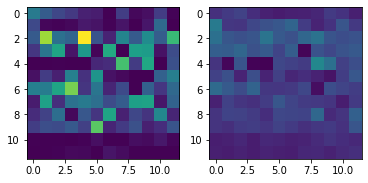

Attention sample min and max values: 2.0408843076587588e-20 | 0.028276657685637474
TOKEN IDS: [7781.0, 121.0]
SAMPLE FROM TOKENS: [neuron | in]


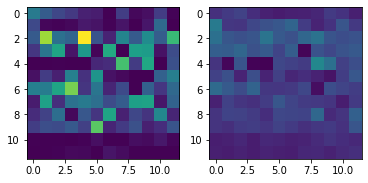

Attention sample min and max values: 1.6615328582030327e-25 | 0.3924642503261566
TOKEN IDS: [6693.0, 3687.0]
SAMPLE FROM TOKENS: [artificial | neural]


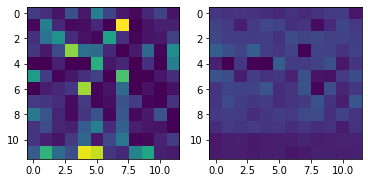

Attention sample min and max values: 1.028648412108868e-12 | 0.6783585548400879
TOKEN IDS: [5728.0, 482.0]
SAMPLE FROM TOKENS: [adding | one]


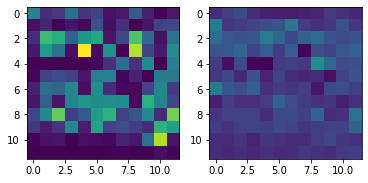

Attention sample min and max values: 2.0730228593958582e-20 | 0.09749115258455276
TOKEN IDS: [198.0, 191.0]
SAMPLE FROM TOKENS: [that | on]


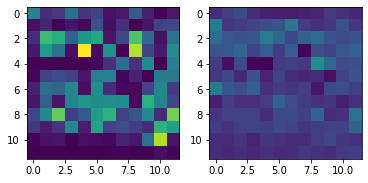

Attention sample min and max values: 6.400841839651352e-24 | 0.3558264970779419
TOKEN IDS: [3997.0, 1904.0]
SAMPLE FROM TOKENS: [machine | learning]


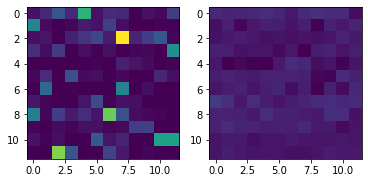

Attention sample min and max values: 5.985972165944986e-06 | 0.7957510948181152
TOKEN IDS: [121.0, 121.0]
SAMPLE FROM TOKENS: [in | in]


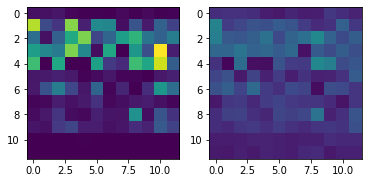

Attention sample min and max values: 4.555161467578728e-06 | 0.7181232571601868
TOKEN IDS: [422.0, 7099.0]
SAMPLE FROM TOKENS: [, | ker]


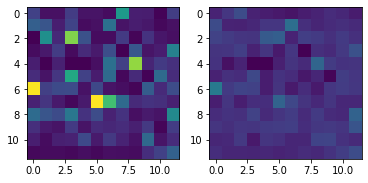

Attention sample min and max values: 7.675424532060937e-12 | 0.9999825954437256
TOKEN IDS: [20020.0, 20020.0]
SAMPLE FROM TOKENS: [maximizes | maximizes]


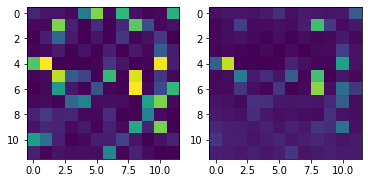

Attention sample min and max values: 2.1737243471544763e-15 | 0.999927282333374
TOKEN IDS: [112.0, 111.0]
SAMPLE FROM TOKENS: [s | the]


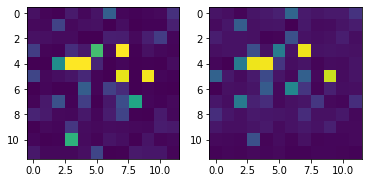

Attention sample min and max values: 2.657269071448809e-08 | 0.9028680920600891
TOKEN IDS: [2810.0, 214.0]
SAMPLE FROM TOKENS: [supported | by]


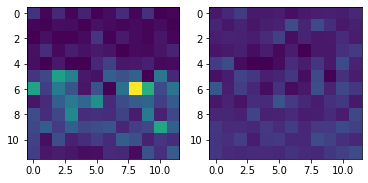

Attention sample min and max values: 1.4136420170302727e-13 | 0.1259744018316269
TOKEN IDS: [4043.0, 3912.0]
SAMPLE FROM TOKENS: [enough | ?]


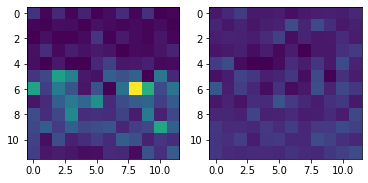

Attention sample min and max values: 3.829118575675413e-19 | 0.10204610228538513
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


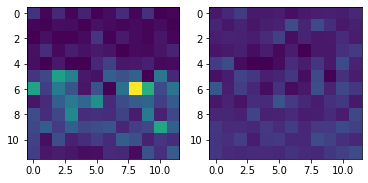

Attention sample min and max values: 2.211139892960531e-25 | 0.041709449142217636
TOKEN IDS: [195.0, 501.0]
SAMPLE FROM TOKENS: [be | used]


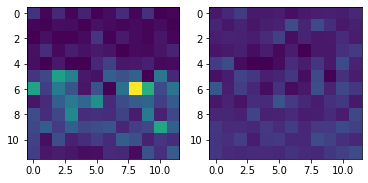

Attention sample min and max values: 2.5625596275623177e-24 | 0.2521747350692749
TOKEN IDS: [546.0, 422.0]
SAMPLE FROM TOKENS: [) | ,]


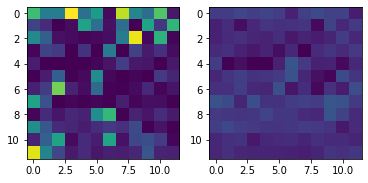

Attention sample min and max values: 1.5509206556175923e-24 | 0.6218644380569458
TOKEN IDS: [111.0, 649.0]
SAMPLE FROM TOKENS: [the | number]


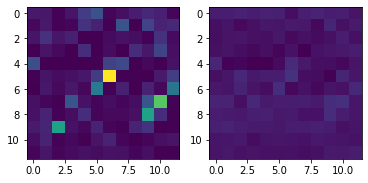

Attention sample min and max values: 1.4048492243646413e-18 | 0.032369621098041534
TOKEN IDS: [3512.0, 2048.0]
SAMPLE FROM TOKENS: [recognition | technology]


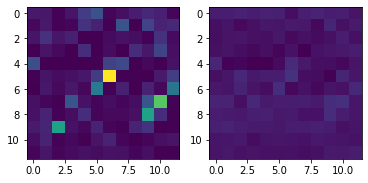

Attention sample min and max values: 1.9162388342763848e-10 | 0.519353985786438
TOKEN IDS: [422.0, 422.0]
SAMPLE FROM TOKENS: [, | ,]


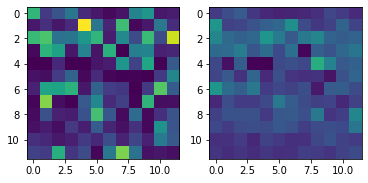

Attention sample min and max values: 1.0553892422400377e-20 | 0.9897152781486511
TOKEN IDS: [30120.0, 30120.0]
SAMPLE FROM TOKENS: [##u | ##u]


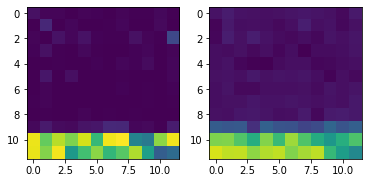

Attention sample min and max values: 4.0688861734229925e-23 | 0.04997851699590683
TOKEN IDS: [579.0, 7951.0]
SAMPLE FROM TOKENS: [- | nn]


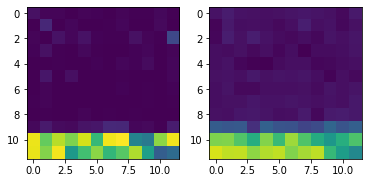

Attention sample min and max values: 8.502183498894598e-34 | 0.058921437710523605
TOKEN IDS: [617.0, 4245.0]
SAMPLE FROM TOKENS: [only | apply]


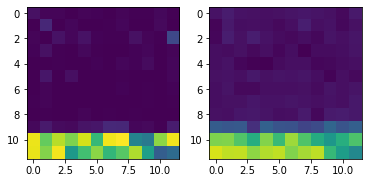

Attention sample min and max values: 2.3062084769049574e-22 | 0.11397156864404678
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


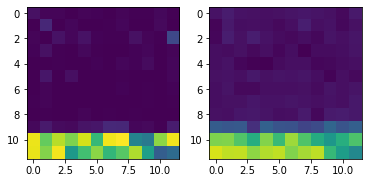

Attention sample min and max values: 1.4622791335232791e-18 | 0.08977624773979187
TOKEN IDS: [158.0, 158.0]
SAMPLE FROM TOKENS: [1 | 1]


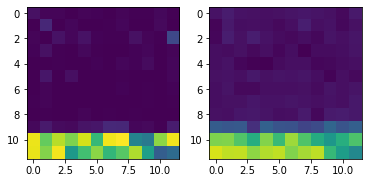

Attention sample min and max values: 9.212943000623918e-28 | 0.1908801794052124
TOKEN IDS: [796.0, 1011.0]
SAMPLE FROM TOKENS: [go | about]


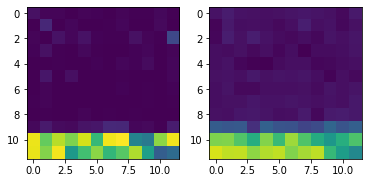

Attention sample min and max values: 9.259602959906055e-25 | 0.5963277816772461
TOKEN IDS: [2244.0, 2244.0]
SAMPLE FROM TOKENS: [fund | fund]


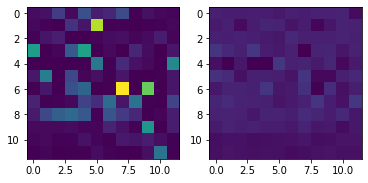

Attention sample min and max values: 1.0906849638558924e-05 | 0.6258540153503418
TOKEN IDS: [6304.0, 716.0]
SAMPLE FROM TOKENS: [deb | ##lu]


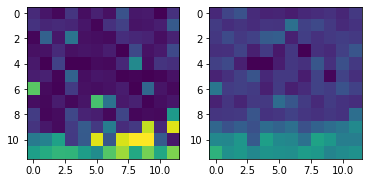

Attention sample min and max values: 8.350966663916748e-20 | 0.168925940990448
TOKEN IDS: [334.0, 334.0]
SAMPLE FROM TOKENS: [which | which]


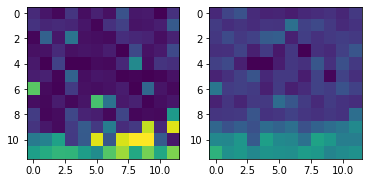

Attention sample min and max values: 3.9399656891424056e-19 | 0.12661349773406982
TOKEN IDS: [121.0, 18231.0]
SAMPLE FROM TOKENS: [in | multin]


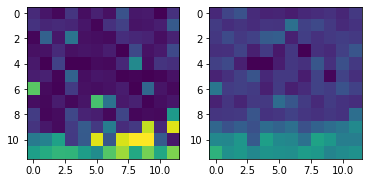

Attention sample min and max values: 6.483799635735751e-24 | 0.567983090877533
TOKEN IDS: [10848.0, 22665.0]
SAMPLE FROM TOKENS: [poisson | intersect]


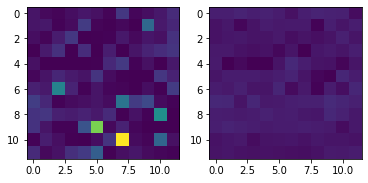

Attention sample min and max values: 6.271646270761266e-06 | 0.8230984807014465
TOKEN IDS: [546.0, 546.0]
SAMPLE FROM TOKENS: [) | )]


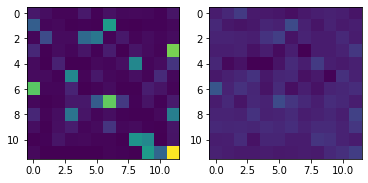

Attention sample min and max values: 1.1298404848245543e-25 | 0.6734122633934021
TOKEN IDS: [106.0, 2702.0]
SAMPLE FROM TOKENS: [a | combination]


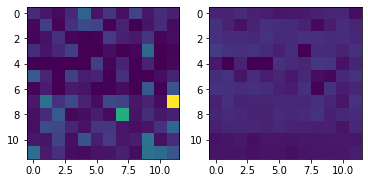

Attention sample min and max values: 8.090077026494214e-18 | 0.3806639313697815
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


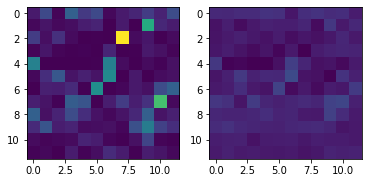

Attention sample min and max values: 1.6675649864460922e-15 | 0.6564232110977173
TOKEN IDS: [804.0, 804.0]
SAMPLE FROM TOKENS: [well | well]


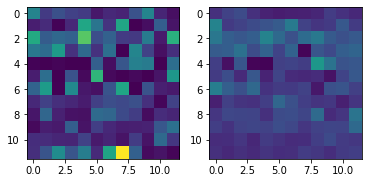

Attention sample min and max values: 1.2008858590260775e-22 | 0.8119308352470398
TOKEN IDS: [7781.0, 121.0]
SAMPLE FROM TOKENS: [neuron | in]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


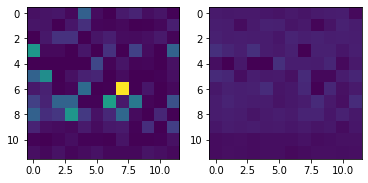

Attention sample min and max values: 3.9570063852428223e-19 | 0.20092608034610748
TOKEN IDS: [6693.0, 3687.0]
SAMPLE FROM TOKENS: [artificial | neural]


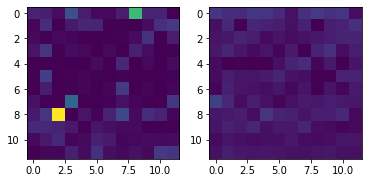

Attention sample min and max values: 6.626534321263478e-10 | 0.3956645727157593
TOKEN IDS: [5728.0, 482.0]
SAMPLE FROM TOKENS: [adding | one]


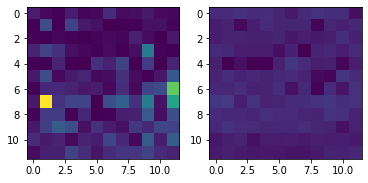

Attention sample min and max values: 9.116573603104302e-25 | 0.2854956388473511
TOKEN IDS: [198.0, 191.0]
SAMPLE FROM TOKENS: [that | on]


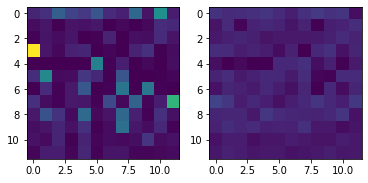

Attention sample min and max values: 6.202441054013165e-26 | 0.16348913311958313
TOKEN IDS: [3997.0, 1904.0]
SAMPLE FROM TOKENS: [machine | learning]


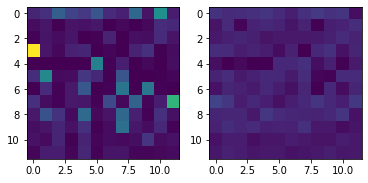

Attention sample min and max values: 6.089577144068894e-16 | 0.014351590536534786
TOKEN IDS: [121.0, 121.0]
SAMPLE FROM TOKENS: [in | in]


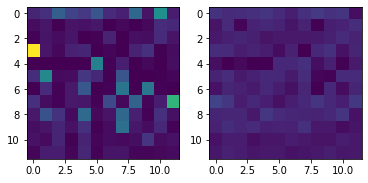

Attention sample min and max values: 2.1909086174849523e-21 | 0.3451692461967468
TOKEN IDS: [422.0, 7099.0]
SAMPLE FROM TOKENS: [, | ker]


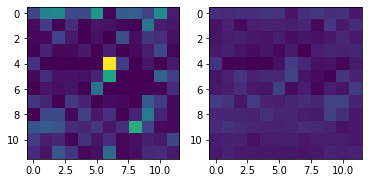

Attention sample min and max values: 2.275360102760726e-22 | 0.010397732257843018
TOKEN IDS: [20020.0, 20020.0]
SAMPLE FROM TOKENS: [maximizes | maximizes]


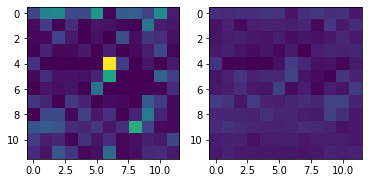

Attention sample min and max values: 5.591165064509047e-26 | 0.8390341401100159
TOKEN IDS: [112.0, 111.0]
SAMPLE FROM TOKENS: [s | the]


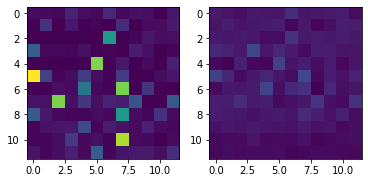

Attention sample min and max values: 4.626390590067864e-11 | 0.9998952150344849
TOKEN IDS: [2810.0, 214.0]
SAMPLE FROM TOKENS: [supported | by]


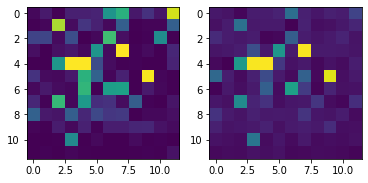

Attention sample min and max values: 5.726098720493751e-22 | 0.159486323595047
TOKEN IDS: [4043.0, 3912.0]
SAMPLE FROM TOKENS: [enough | ?]


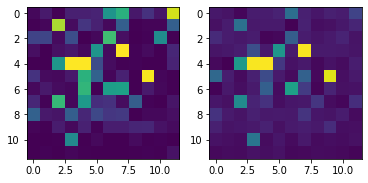

Attention sample min and max values: 7.980746414263488e-17 | 0.27141016721725464
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


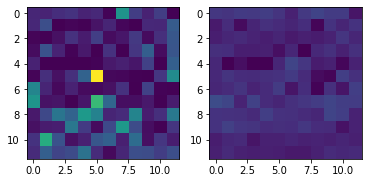

Attention sample min and max values: 1.7043684598760005e-27 | 0.3217615783214569
TOKEN IDS: [195.0, 501.0]
SAMPLE FROM TOKENS: [be | used]


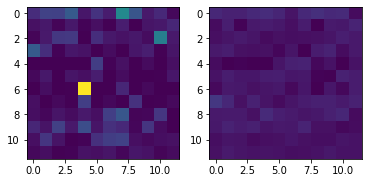

Attention sample min and max values: 4.358091917401087e-14 | 0.9918450713157654
TOKEN IDS: [546.0, 422.0]
SAMPLE FROM TOKENS: [) | ,]


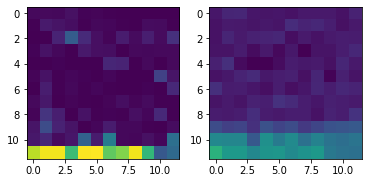

Attention sample min and max values: 4.861163714741696e-20 | 0.02264087274670601
TOKEN IDS: [111.0, 649.0]
SAMPLE FROM TOKENS: [the | number]


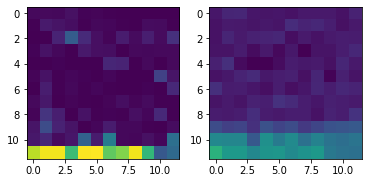

Attention sample min and max values: 3.226942817889659e-23 | 0.07679446786642075
TOKEN IDS: [3512.0, 2048.0]
SAMPLE FROM TOKENS: [recognition | technology]


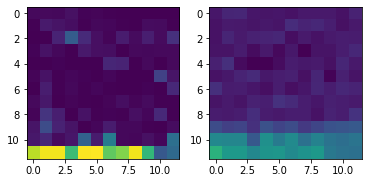

Attention sample min and max values: 4.440955603257635e-09 | 0.05744432285428047
TOKEN IDS: [422.0, 422.0]
SAMPLE FROM TOKENS: [, | ,]


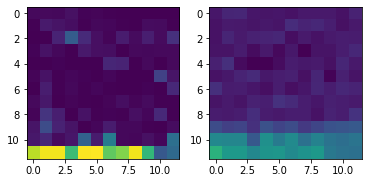

Attention sample min and max values: 8.198110593160557e-12 | 0.23742590844631195
TOKEN IDS: [30120.0, 30120.0]
SAMPLE FROM TOKENS: [##u | ##u]


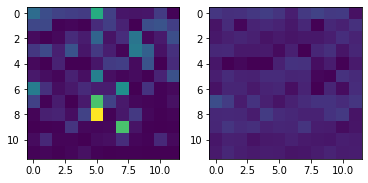

Attention sample min and max values: 2.914924974572325e-14 | 0.4360235929489136
TOKEN IDS: [579.0, 7951.0]
SAMPLE FROM TOKENS: [- | nn]


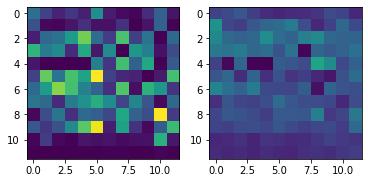

Attention sample min and max values: 3.178954699478709e-08 | 0.9993317723274231
TOKEN IDS: [617.0, 4245.0]
SAMPLE FROM TOKENS: [only | apply]


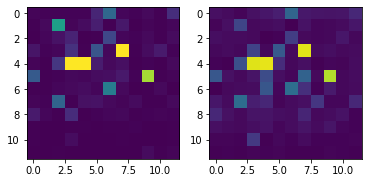

Attention sample min and max values: 4.732363088911239e-27 | 0.10022465139627457
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


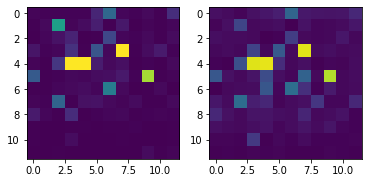

Attention sample min and max values: 3.2011341781364416e-16 | 0.2855744957923889
TOKEN IDS: [158.0, 158.0]
SAMPLE FROM TOKENS: [1 | 1]


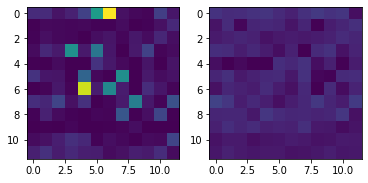

Attention sample min and max values: 1.7870424107516159e-12 | 0.999958872795105
TOKEN IDS: [796.0, 1011.0]
SAMPLE FROM TOKENS: [go | about]


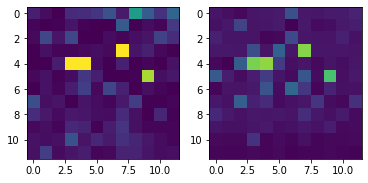

Attention sample min and max values: 5.0080002443242855e-16 | 0.20648100972175598
TOKEN IDS: [2244.0, 2244.0]
SAMPLE FROM TOKENS: [fund | fund]


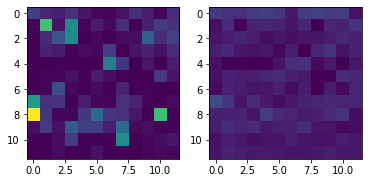

Attention sample min and max values: 2.2853281164953268e-27 | 0.40981563925743103
TOKEN IDS: [6304.0, 716.0]
SAMPLE FROM TOKENS: [deb | ##lu]


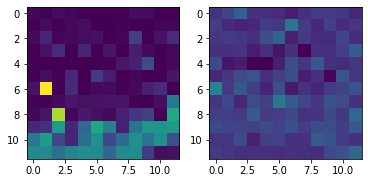

Attention sample min and max values: 2.3503278314510214e-18 | 0.6616460084915161
TOKEN IDS: [334.0, 334.0]
SAMPLE FROM TOKENS: [which | which]


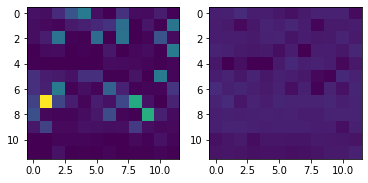

Attention sample min and max values: 1.1747265489248093e-05 | 0.9291659593582153
TOKEN IDS: [121.0, 18231.0]
SAMPLE FROM TOKENS: [in | multin]


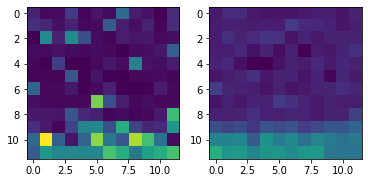

Attention sample min and max values: 6.769217931692549e-33 | 0.06766670197248459
TOKEN IDS: [10848.0, 22665.0]
SAMPLE FROM TOKENS: [poisson | intersect]


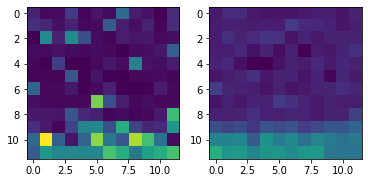

Attention sample min and max values: 1.8573063583735992e-22 | 0.06215286627411842
TOKEN IDS: [546.0, 546.0]
SAMPLE FROM TOKENS: [) | )]


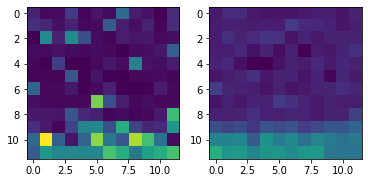

Attention sample min and max values: 2.2867909636351902e-15 | 0.03727124631404877
TOKEN IDS: [106.0, 2702.0]
SAMPLE FROM TOKENS: [a | combination]


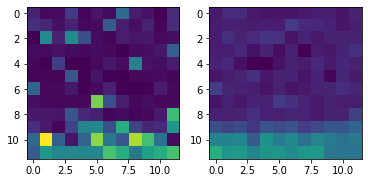

Attention sample min and max values: 2.4516129955308425e-18 | 0.2919873595237732
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


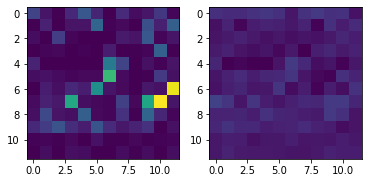

Attention sample min and max values: 1.0343918083188797e-10 | 0.498190313577652
TOKEN IDS: [804.0, 804.0]
SAMPLE FROM TOKENS: [well | well]


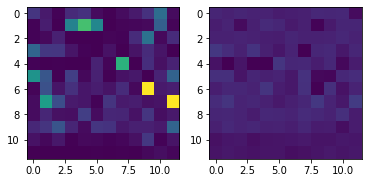

Attention sample min and max values: 6.857601557192645e-39 | 0.3235413432121277
TOKEN IDS: [7781.0, 121.0]
SAMPLE FROM TOKENS: [neuron | in]


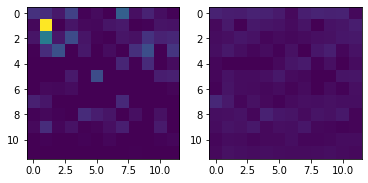

Attention sample min and max values: 5.203406835375428e-37 | 0.015611152164638042
TOKEN IDS: [6693.0, 3687.0]
SAMPLE FROM TOKENS: [artificial | neural]


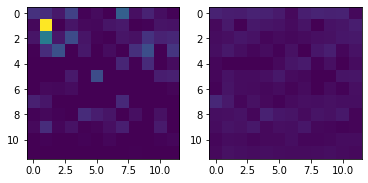

Attention sample min and max values: 4.7824920530219405e-19 | 0.5629335641860962
TOKEN IDS: [5728.0, 482.0]
SAMPLE FROM TOKENS: [adding | one]


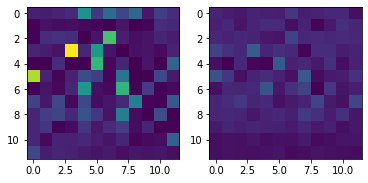

Attention sample min and max values: 2.90167850300213e-20 | 0.07018008828163147
TOKEN IDS: [198.0, 191.0]
SAMPLE FROM TOKENS: [that | on]


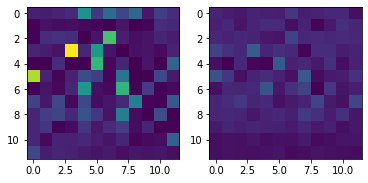

Attention sample min and max values: 5.617844431075547e-32 | 0.0779111459851265
TOKEN IDS: [3997.0, 1904.0]
SAMPLE FROM TOKENS: [machine | learning]


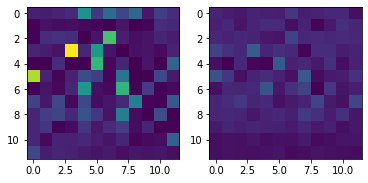

Attention sample min and max values: 3.0288857568205065e-27 | 0.04040655121207237
TOKEN IDS: [121.0, 121.0]
SAMPLE FROM TOKENS: [in | in]


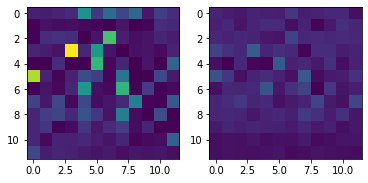

Attention sample min and max values: 2.5367985708191668e-28 | 0.16692210733890533
TOKEN IDS: [422.0, 7099.0]
SAMPLE FROM TOKENS: [, | ker]


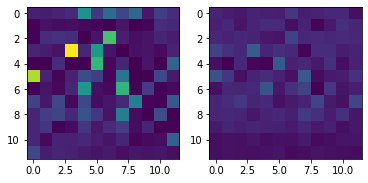

Attention sample min and max values: 2.0169789944409367e-15 | 0.21066394448280334
TOKEN IDS: [20020.0, 20020.0]
SAMPLE FROM TOKENS: [maximizes | maximizes]


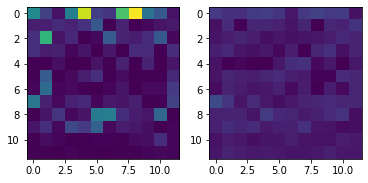

Attention sample min and max values: 1.5144095446514735e-16 | 0.3951740264892578
TOKEN IDS: [112.0, 111.0]
SAMPLE FROM TOKENS: [s | the]


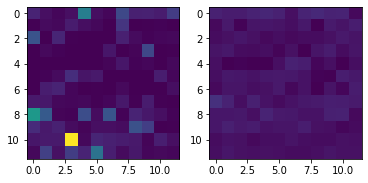

Attention sample min and max values: 1.5790674345830076e-25 | 0.1553507000207901
TOKEN IDS: [2810.0, 214.0]
SAMPLE FROM TOKENS: [supported | by]


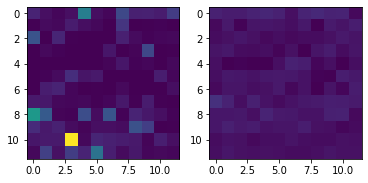

Attention sample min and max values: 2.689140051198855e-25 | 0.1779162883758545
TOKEN IDS: [4043.0, 3912.0]
SAMPLE FROM TOKENS: [enough | ?]


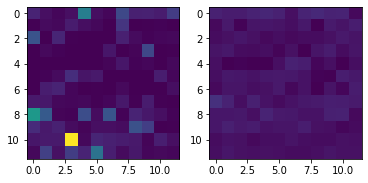

Attention sample min and max values: 4.592169422501513e-10 | 0.1219879686832428
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


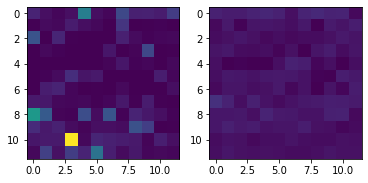

Attention sample min and max values: 4.354355209734706e-10 | 0.9997684359550476
TOKEN IDS: [195.0, 501.0]
SAMPLE FROM TOKENS: [be | used]


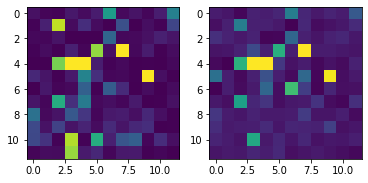

Attention sample min and max values: 4.074793201148032e-29 | 0.09945657849311829
TOKEN IDS: [546.0, 422.0]
SAMPLE FROM TOKENS: [) | ,]


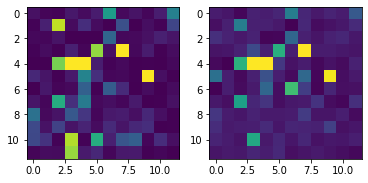

Attention sample min and max values: 7.214110259052083e-23 | 0.9537596702575684
TOKEN IDS: [111.0, 649.0]
SAMPLE FROM TOKENS: [the | number]


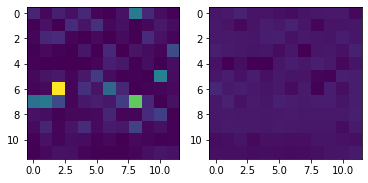

Attention sample min and max values: 1.9296324573029833e-18 | 0.27712059020996094
TOKEN IDS: [3512.0, 2048.0]
SAMPLE FROM TOKENS: [recognition | technology]


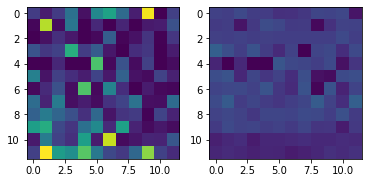

Attention sample min and max values: 4.951516627271779e-13 | 0.5888103246688843
TOKEN IDS: [422.0, 422.0]
SAMPLE FROM TOKENS: [, | ,]


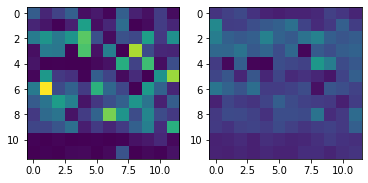

Attention sample min and max values: 2.988286140769377e-22 | 0.3463135361671448
TOKEN IDS: [30120.0, 30120.0]
SAMPLE FROM TOKENS: [##u | ##u]


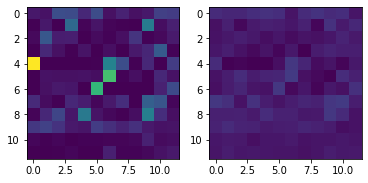

Attention sample min and max values: 9.132003313261361e-12 | 0.015373620204627514
TOKEN IDS: [579.0, 7951.0]
SAMPLE FROM TOKENS: [- | nn]


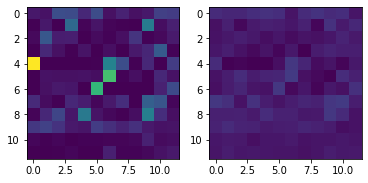

Attention sample min and max values: 7.266993014464777e-28 | 0.03655049949884415
TOKEN IDS: [617.0, 4245.0]
SAMPLE FROM TOKENS: [only | apply]


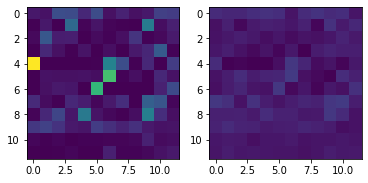

Attention sample min and max values: 5.1292073886821665e-12 | 0.2915937900543213
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


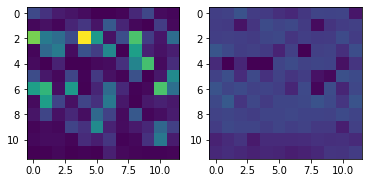

Attention sample min and max values: 2.5138177143025633e-20 | 0.6184267997741699
TOKEN IDS: [158.0, 158.0]
SAMPLE FROM TOKENS: [1 | 1]


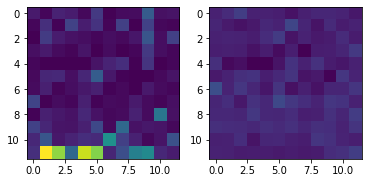

Attention sample min and max values: 5.629758161811404e-17 | 0.29703816771507263
TOKEN IDS: [796.0, 1011.0]
SAMPLE FROM TOKENS: [go | about]


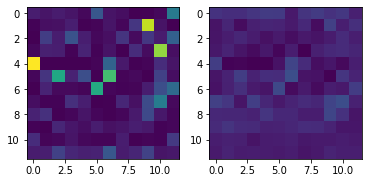

Attention sample min and max values: 7.027964783352772e-21 | 0.29854899644851685
TOKEN IDS: [2244.0, 2244.0]
SAMPLE FROM TOKENS: [fund | fund]


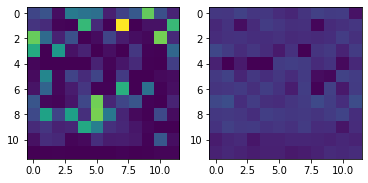

Attention sample min and max values: 8.815323145928977e-13 | 0.13915060460567474
TOKEN IDS: [6304.0, 716.0]
SAMPLE FROM TOKENS: [deb | ##lu]


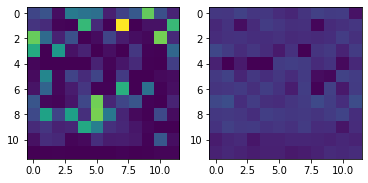

Attention sample min and max values: 1.0585157264615467e-21 | 0.9710325002670288
TOKEN IDS: [334.0, 334.0]
SAMPLE FROM TOKENS: [which | which]


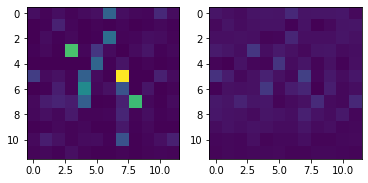

Attention sample min and max values: 4.536874651394124e-28 | 0.03638550266623497
TOKEN IDS: [121.0, 18231.0]
SAMPLE FROM TOKENS: [in | multin]


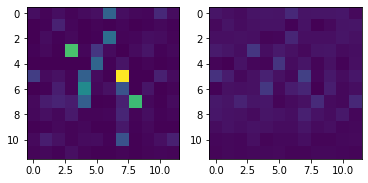

Attention sample min and max values: 5.160512642210513e-11 | 0.153252512216568
TOKEN IDS: [10848.0, 22665.0]
SAMPLE FROM TOKENS: [poisson | intersect]


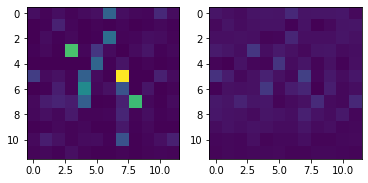

Attention sample min and max values: 2.2432678697064225e-15 | 0.07550646364688873
TOKEN IDS: [546.0, 546.0]
SAMPLE FROM TOKENS: [) | )]


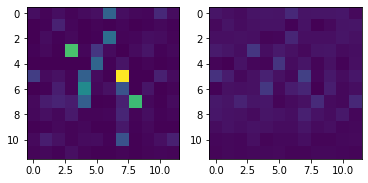

Attention sample min and max values: 1.239623770743492e-06 | 0.6266872882843018
TOKEN IDS: [106.0, 2702.0]
SAMPLE FROM TOKENS: [a | combination]


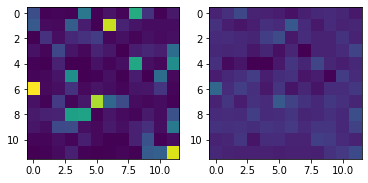

Attention sample min and max values: 1.6907273141469979e-15 | 0.31992608308792114
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


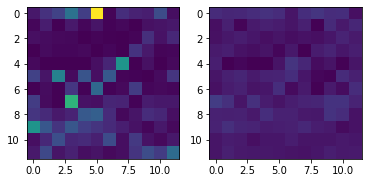

Attention sample min and max values: 2.1841854324066148e-20 | 0.11007359623908997
TOKEN IDS: [804.0, 804.0]
SAMPLE FROM TOKENS: [well | well]


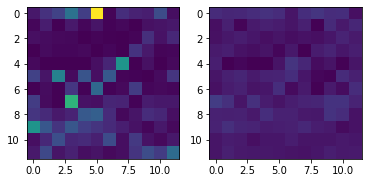

Attention sample min and max values: 1.1326988413884465e-07 | 0.9416409134864807
TOKEN IDS: [7781.0, 121.0]
SAMPLE FROM TOKENS: [neuron | in]


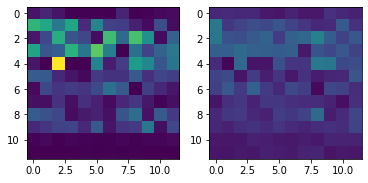

Attention sample min and max values: 6.141838882096906e-13 | 0.9999971389770508
TOKEN IDS: [6693.0, 3687.0]
SAMPLE FROM TOKENS: [artificial | neural]


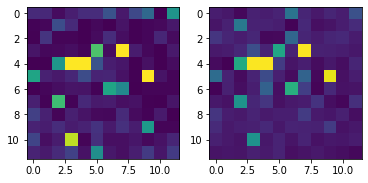

Attention sample min and max values: 1.9219085290862987e-19 | 0.048200733959674835
TOKEN IDS: [5728.0, 482.0]
SAMPLE FROM TOKENS: [adding | one]


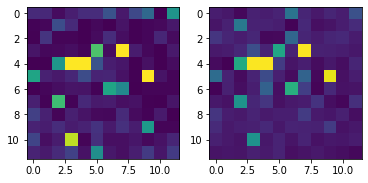

Attention sample min and max values: 3.6338297822180454e-12 | 0.16087420284748077
TOKEN IDS: [198.0, 191.0]
SAMPLE FROM TOKENS: [that | on]


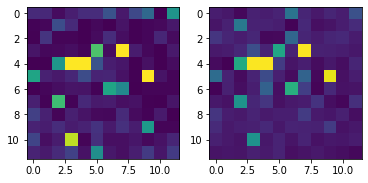

Attention sample min and max values: 2.37606267126933e-13 | 0.06810826063156128
TOKEN IDS: [3997.0, 1904.0]
SAMPLE FROM TOKENS: [machine | learning]


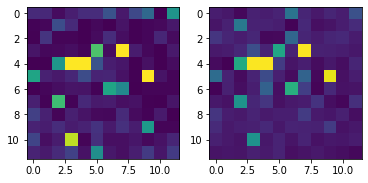

Attention sample min and max values: 2.0192503313865018e-07 | 0.7558085918426514
TOKEN IDS: [121.0, 121.0]
SAMPLE FROM TOKENS: [in | in]


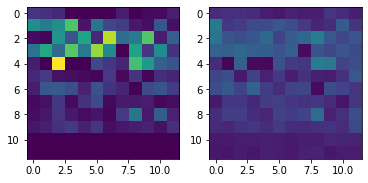

Attention sample min and max values: 1.9877113768938742e-21 | 0.4118567705154419
TOKEN IDS: [422.0, 7099.0]
SAMPLE FROM TOKENS: [, | ker]


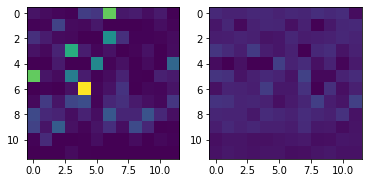

Attention sample min and max values: 2.3669922767027715e-29 | 0.31470203399658203
TOKEN IDS: [20020.0, 20020.0]
SAMPLE FROM TOKENS: [maximizes | maximizes]


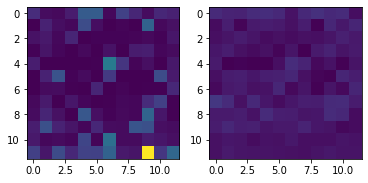

Attention sample min and max values: 1.777454424424469e-21 | 0.03840811923146248
TOKEN IDS: [112.0, 111.0]
SAMPLE FROM TOKENS: [s | the]


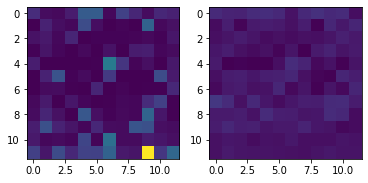

Attention sample min and max values: 2.2907667140118734e-23 | 0.36993467807769775
TOKEN IDS: [2810.0, 214.0]
SAMPLE FROM TOKENS: [supported | by]


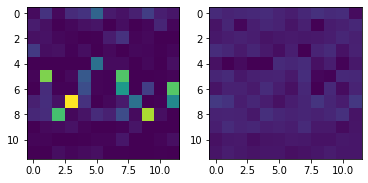

Attention sample min and max values: 1.3033782386706605e-10 | 0.6204208731651306
TOKEN IDS: [4043.0, 3912.0]
SAMPLE FROM TOKENS: [enough | ?]


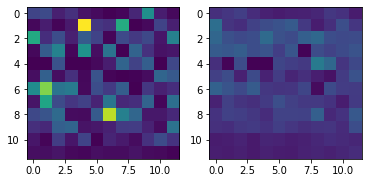

Attention sample min and max values: 2.73182786663754e-28 | 0.23163418471813202
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


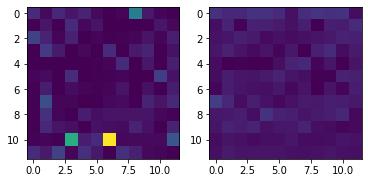

Attention sample min and max values: 4.523128833283652e-15 | 0.9999972581863403
TOKEN IDS: [195.0, 501.0]
SAMPLE FROM TOKENS: [be | used]


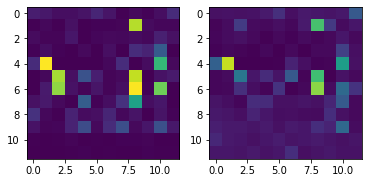

Attention sample min and max values: 2.820709256658129e-18 | 0.03901326283812523
TOKEN IDS: [546.0, 422.0]
SAMPLE FROM TOKENS: [) | ,]


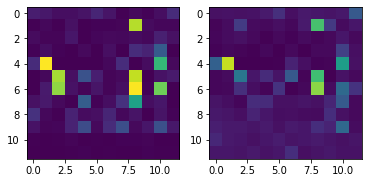

Attention sample min and max values: 7.967171811174012e-09 | 0.34347036480903625
TOKEN IDS: [111.0, 649.0]
SAMPLE FROM TOKENS: [the | number]


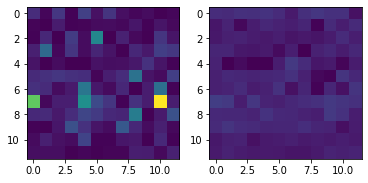

Attention sample min and max values: 1.188594524137443e-05 | 0.7940362691879272
TOKEN IDS: [3512.0, 2048.0]
SAMPLE FROM TOKENS: [recognition | technology]


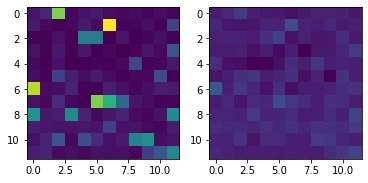

Attention sample min and max values: 4.348957491598584e-18 | 0.0959378257393837
TOKEN IDS: [422.0, 422.0]
SAMPLE FROM TOKENS: [, | ,]


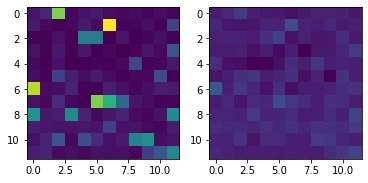

Attention sample min and max values: 8.742653486066799e-20 | 0.08757605403661728
TOKEN IDS: [30120.0, 30120.0]
SAMPLE FROM TOKENS: [##u | ##u]


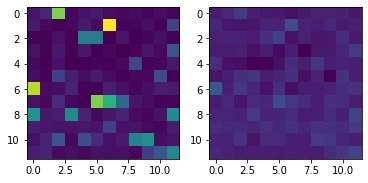

Attention sample min and max values: 5.299399641187028e-21 | 0.9819720387458801
TOKEN IDS: [579.0, 7951.0]
SAMPLE FROM TOKENS: [- | nn]


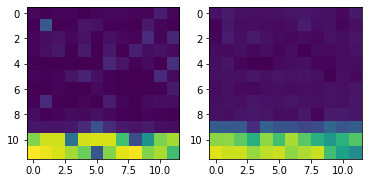

Attention sample min and max values: 2.651162709499705e-24 | 0.17539618909358978
TOKEN IDS: [617.0, 4245.0]
SAMPLE FROM TOKENS: [only | apply]


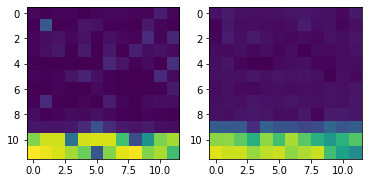

Attention sample min and max values: 1.6506725999086702e-13 | 0.9998456239700317
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


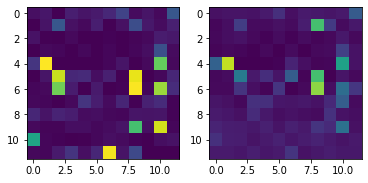

Attention sample min and max values: 6.959721171126797e-22 | 0.02317792922258377
TOKEN IDS: [158.0, 158.0]
SAMPLE FROM TOKENS: [1 | 1]


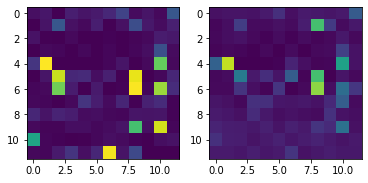

Attention sample min and max values: 6.653525031646315e-24 | 0.33121320605278015
TOKEN IDS: [796.0, 1011.0]
SAMPLE FROM TOKENS: [go | about]


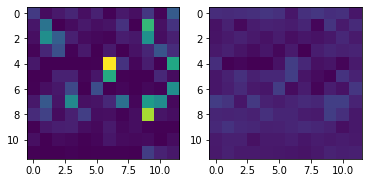

Attention sample min and max values: 4.572366011474597e-15 | 0.03840417414903641
TOKEN IDS: [2244.0, 2244.0]
SAMPLE FROM TOKENS: [fund | fund]


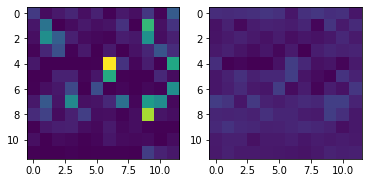

Attention sample min and max values: 2.442484685616364e-07 | 0.13104042410850525
TOKEN IDS: [6304.0, 716.0]
SAMPLE FROM TOKENS: [deb | ##lu]


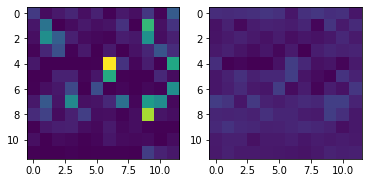

Attention sample min and max values: 3.149659164591867e-07 | 0.6654583811759949
TOKEN IDS: [334.0, 334.0]
SAMPLE FROM TOKENS: [which | which]


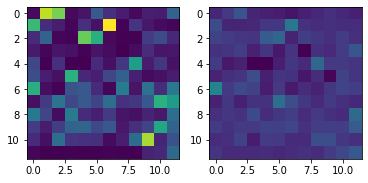

Attention sample min and max values: 6.629810733594006e-19 | 0.3745371699333191
TOKEN IDS: [121.0, 18231.0]
SAMPLE FROM TOKENS: [in | multin]


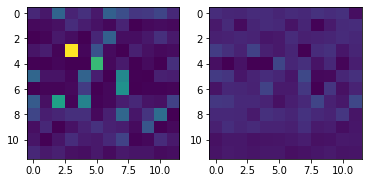

Attention sample min and max values: 9.930368349841956e-08 | 0.8358861207962036
TOKEN IDS: [10848.0, 22665.0]
SAMPLE FROM TOKENS: [poisson | intersect]


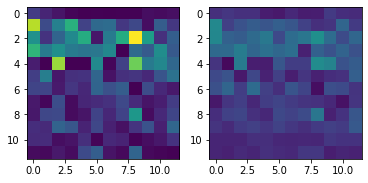

Attention sample min and max values: 3.3200508806069265e-15 | 0.644275963306427
TOKEN IDS: [546.0, 546.0]
SAMPLE FROM TOKENS: [) | )]


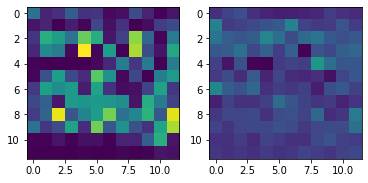

Attention sample min and max values: 4.6835324951643997e-07 | 0.29887282848358154
TOKEN IDS: [106.0, 2702.0]
SAMPLE FROM TOKENS: [a | combination]


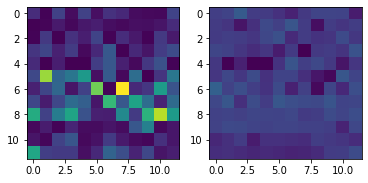

Attention sample min and max values: 1.8885637845245107e-11 | 0.999561607837677
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


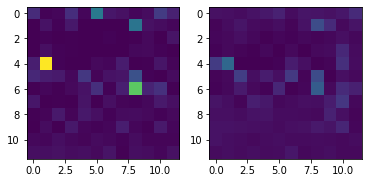

Attention sample min and max values: 6.695660927563047e-26 | 0.07661990076303482
TOKEN IDS: [804.0, 804.0]
SAMPLE FROM TOKENS: [well | well]


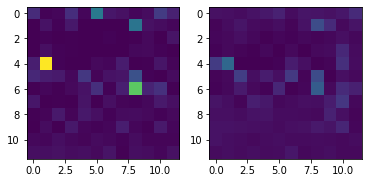

Attention sample min and max values: 4.16612832227472e-28 | 0.2079223245382309
TOKEN IDS: [7781.0, 121.0]
SAMPLE FROM TOKENS: [neuron | in]


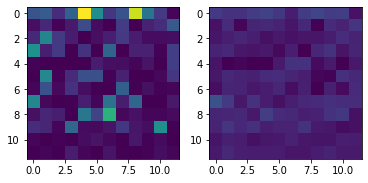

Attention sample min and max values: 3.793946493774181e-12 | 0.06721032410860062
TOKEN IDS: [6693.0, 3687.0]
SAMPLE FROM TOKENS: [artificial | neural]


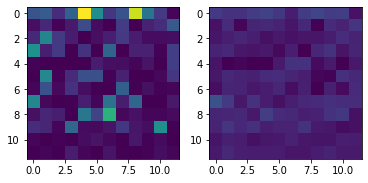

Attention sample min and max values: 1.6183562328851842e-24 | 0.19302809238433838
TOKEN IDS: [5728.0, 482.0]
SAMPLE FROM TOKENS: [adding | one]


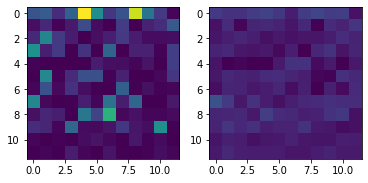

Attention sample min and max values: 1.4220076799650125e-17 | 0.10093548148870468
TOKEN IDS: [198.0, 191.0]
SAMPLE FROM TOKENS: [that | on]


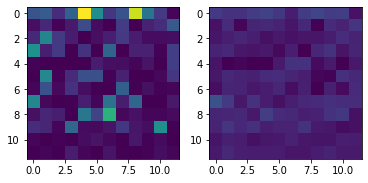

Attention sample min and max values: 1.6545182438386526e-15 | 0.15557894110679626
TOKEN IDS: [3997.0, 1904.0]
SAMPLE FROM TOKENS: [machine | learning]


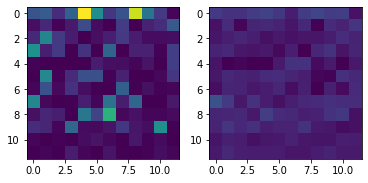

Attention sample min and max values: 3.932295908706286e-14 | 0.2511458098888397
TOKEN IDS: [121.0, 121.0]
SAMPLE FROM TOKENS: [in | in]


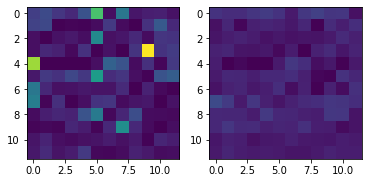

Attention sample min and max values: 2.917328379738182e-13 | 0.9997326731681824
TOKEN IDS: [422.0, 7099.0]
SAMPLE FROM TOKENS: [, | ker]


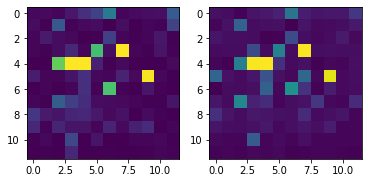

Attention sample min and max values: 2.0781648429023247e-14 | 0.044295307248830795
TOKEN IDS: [20020.0, 20020.0]
SAMPLE FROM TOKENS: [maximizes | maximizes]


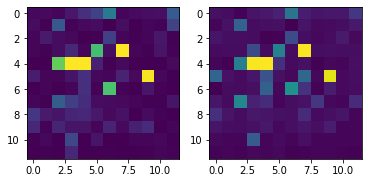

Attention sample min and max values: 5.707411292778468e-19 | 0.5778372883796692
TOKEN IDS: [112.0, 111.0]
SAMPLE FROM TOKENS: [s | the]


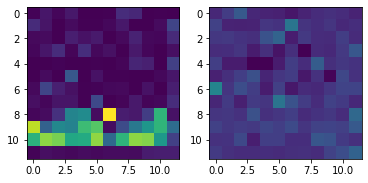

Attention sample min and max values: 6.073671087769619e-22 | 0.6517370343208313
TOKEN IDS: [2810.0, 214.0]
SAMPLE FROM TOKENS: [supported | by]


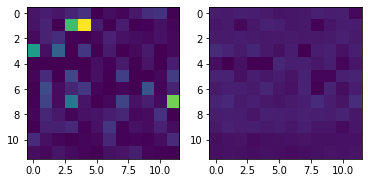

Attention sample min and max values: 2.796940634652856e-07 | 0.39402541518211365
TOKEN IDS: [4043.0, 3912.0]
SAMPLE FROM TOKENS: [enough | ?]


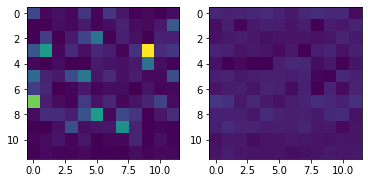

Attention sample min and max values: 1.137282157337438e-09 | 0.9999667406082153
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


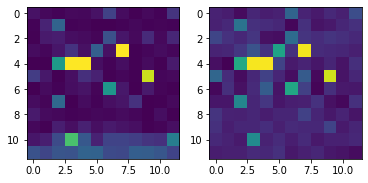

Attention sample min and max values: 4.514872211411862e-26 | 0.5191263556480408
TOKEN IDS: [195.0, 501.0]
SAMPLE FROM TOKENS: [be | used]


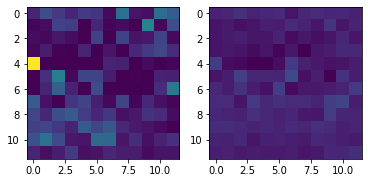

Attention sample min and max values: 7.60124149659793e-30 | 0.11977718025445938
TOKEN IDS: [546.0, 422.0]
SAMPLE FROM TOKENS: [) | ,]


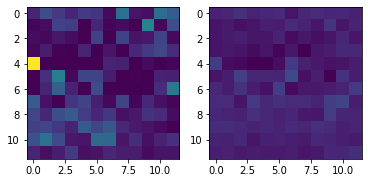

Attention sample min and max values: 5.173008220734773e-21 | 0.633796215057373
TOKEN IDS: [111.0, 649.0]
SAMPLE FROM TOKENS: [the | number]


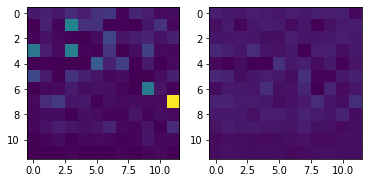

Attention sample min and max values: 8.970230699727189e-13 | 0.9999983310699463
TOKEN IDS: [3512.0, 2048.0]
SAMPLE FROM TOKENS: [recognition | technology]


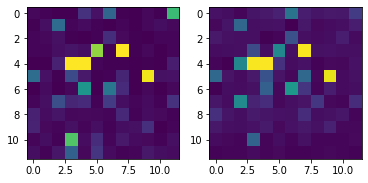

Attention sample min and max values: 1.1540231391336209e-25 | 0.024598458781838417
TOKEN IDS: [422.0, 422.0]
SAMPLE FROM TOKENS: [, | ,]


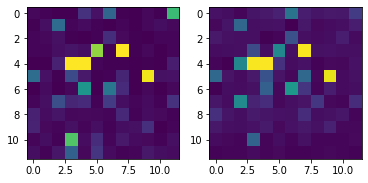

Attention sample min and max values: 3.910531620743285e-10 | 0.4382268190383911
TOKEN IDS: [30120.0, 30120.0]
SAMPLE FROM TOKENS: [##u | ##u]


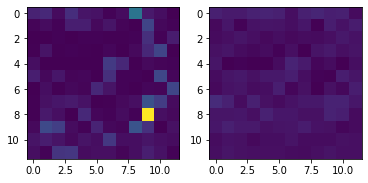

Attention sample min and max values: 2.261281124691543e-25 | 0.024645645171403885
TOKEN IDS: [579.0, 7951.0]
SAMPLE FROM TOKENS: [- | nn]


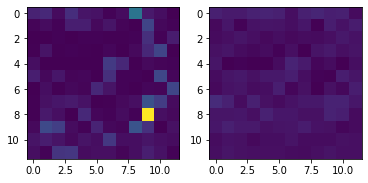

Attention sample min and max values: 4.3481702095258896e-20 | 0.25320109724998474
TOKEN IDS: [617.0, 4245.0]
SAMPLE FROM TOKENS: [only | apply]


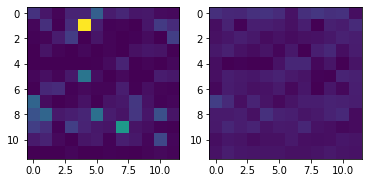

Attention sample min and max values: 6.070734758153769e-22 | 0.8363757729530334
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


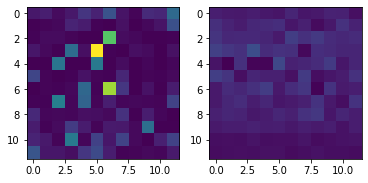

Attention sample min and max values: 7.3689589044079185e-06 | 0.9796614646911621
TOKEN IDS: [158.0, 158.0]
SAMPLE FROM TOKENS: [1 | 1]


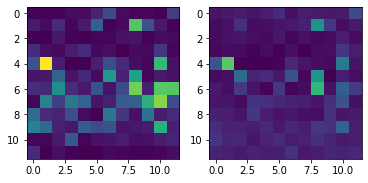

Attention sample min and max values: 2.5245267859547743e-28 | 0.4784229099750519
TOKEN IDS: [796.0, 1011.0]
SAMPLE FROM TOKENS: [go | about]


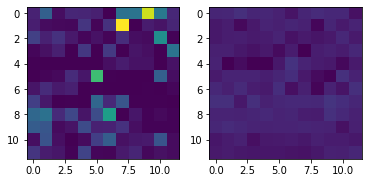

Attention sample min and max values: 6.653933905195467e-19 | 0.17363370954990387
TOKEN IDS: [2244.0, 2244.0]
SAMPLE FROM TOKENS: [fund | fund]


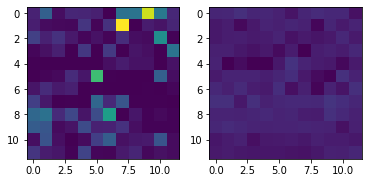

Attention sample min and max values: 2.4072277916668827e-13 | 0.28532031178474426
TOKEN IDS: [6304.0, 716.0]
SAMPLE FROM TOKENS: [deb | ##lu]


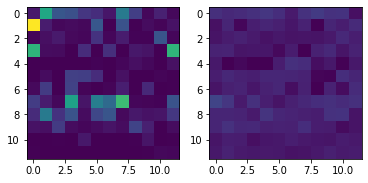

Attention sample min and max values: 1.3910301060941456e-28 | 0.16472582519054413
TOKEN IDS: [334.0, 334.0]
SAMPLE FROM TOKENS: [which | which]


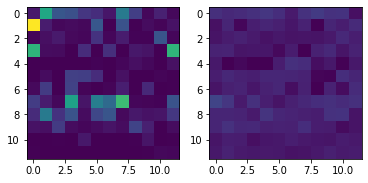

Attention sample min and max values: 6.147393249826549e-13 | 0.9999947547912598
TOKEN IDS: [121.0, 18231.0]
SAMPLE FROM TOKENS: [in | multin]


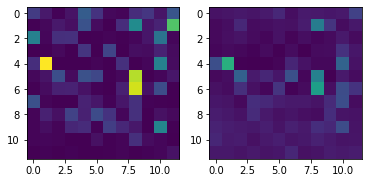

Attention sample min and max values: 5.3736179369722086e-20 | 0.6750585436820984
TOKEN IDS: [10848.0, 22665.0]
SAMPLE FROM TOKENS: [poisson | intersect]


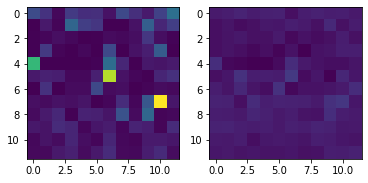

Attention sample min and max values: 1.6872637879987725e-20 | 0.47051823139190674
TOKEN IDS: [546.0, 546.0]
SAMPLE FROM TOKENS: [) | )]


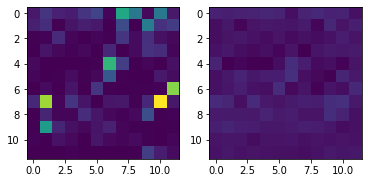

Attention sample min and max values: 3.1985624424190656e-23 | 0.02001582272350788
TOKEN IDS: [106.0, 2702.0]
SAMPLE FROM TOKENS: [a | combination]


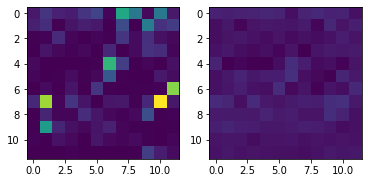

Attention sample min and max values: 1.180606457040767e-08 | 0.35197019577026367
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


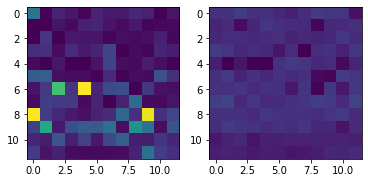

Attention sample min and max values: 2.2358307425526108e-13 | 0.9999022483825684
TOKEN IDS: [804.0, 804.0]
SAMPLE FROM TOKENS: [well | well]


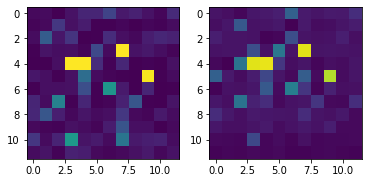

Attention sample min and max values: 2.4607670501969325e-13 | 0.9993587136268616
TOKEN IDS: [7781.0, 121.0]
SAMPLE FROM TOKENS: [neuron | in]


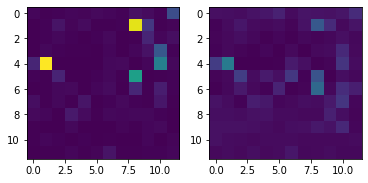

Attention sample min and max values: 2.113230290745789e-27 | 0.9673721194267273
TOKEN IDS: [6693.0, 3687.0]
SAMPLE FROM TOKENS: [artificial | neural]


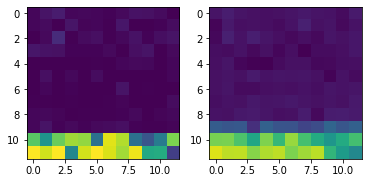

Attention sample min and max values: 4.532738555060437e-25 | 0.07279207557439804
TOKEN IDS: [5728.0, 482.0]
SAMPLE FROM TOKENS: [adding | one]


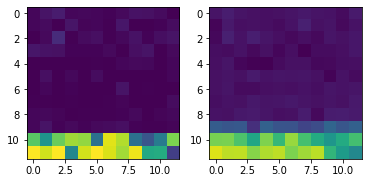

Attention sample min and max values: 2.679630591061028e-29 | 0.10912422835826874
TOKEN IDS: [198.0, 191.0]
SAMPLE FROM TOKENS: [that | on]


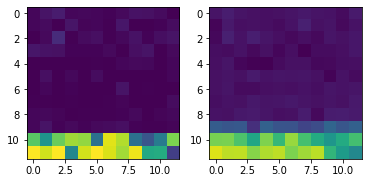

Attention sample min and max values: 2.5004918136062315e-09 | 0.7131956219673157
TOKEN IDS: [3997.0, 1904.0]
SAMPLE FROM TOKENS: [machine | learning]


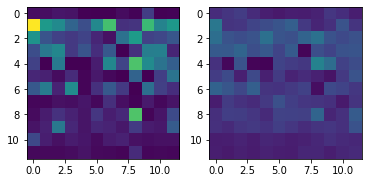

Attention sample min and max values: 3.617915567133423e-08 | 0.11873176693916321
TOKEN IDS: [121.0, 121.0]
SAMPLE FROM TOKENS: [in | in]


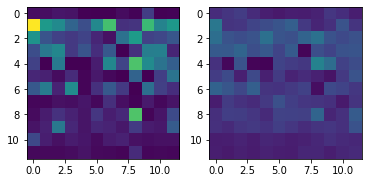

Attention sample min and max values: 7.827814377213613e-27 | 0.058086443692445755
TOKEN IDS: [422.0, 7099.0]
SAMPLE FROM TOKENS: [, | ker]


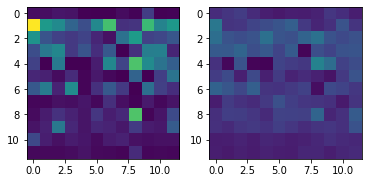

Attention sample min and max values: 1.202017818613399e-09 | 0.9094738960266113
TOKEN IDS: [20020.0, 20020.0]
SAMPLE FROM TOKENS: [maximizes | maximizes]


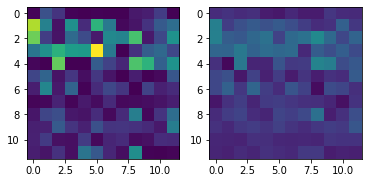

Attention sample min and max values: 9.758905614664428e-21 | 0.3347945511341095
TOKEN IDS: [112.0, 111.0]
SAMPLE FROM TOKENS: [s | the]


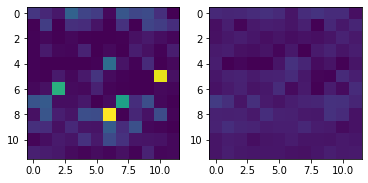

Attention sample min and max values: 8.715161925465509e-08 | 0.12604252994060516
TOKEN IDS: [2810.0, 214.0]
SAMPLE FROM TOKENS: [supported | by]


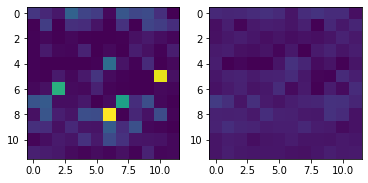

Attention sample min and max values: 1.1531268455655663e-06 | 0.8593483567237854
TOKEN IDS: [4043.0, 3912.0]
SAMPLE FROM TOKENS: [enough | ?]


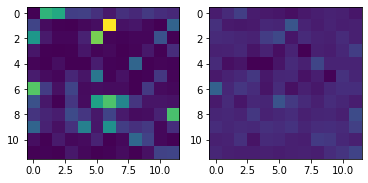

Attention sample min and max values: 9.46023391448787e-23 | 0.07253086566925049
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


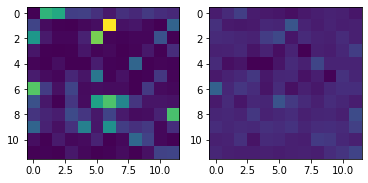

Attention sample min and max values: 1.2915687408465715e-09 | 0.1344485878944397
TOKEN IDS: [195.0, 501.0]
SAMPLE FROM TOKENS: [be | used]


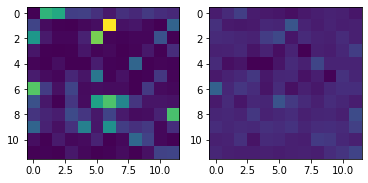

Attention sample min and max values: 4.297188282870215e-32 | 0.01988312415778637
TOKEN IDS: [546.0, 422.0]
SAMPLE FROM TOKENS: [) | ,]


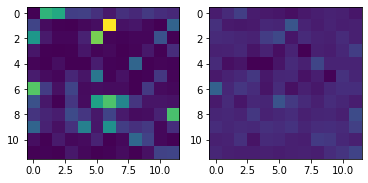

Attention sample min and max values: 1.9999505641882333e-19 | 0.19066940248012543
TOKEN IDS: [111.0, 649.0]
SAMPLE FROM TOKENS: [the | number]


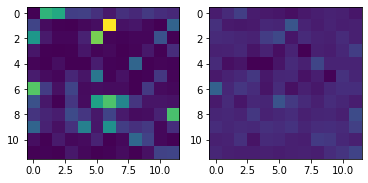

Attention sample min and max values: 1.4468018383139623e-25 | 0.13484960794448853
TOKEN IDS: [3512.0, 2048.0]
SAMPLE FROM TOKENS: [recognition | technology]


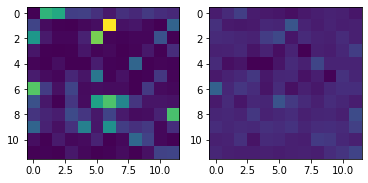

Attention sample min and max values: 3.1882118491921574e-05 | 0.528165340423584
TOKEN IDS: [422.0, 422.0]
SAMPLE FROM TOKENS: [, | ,]


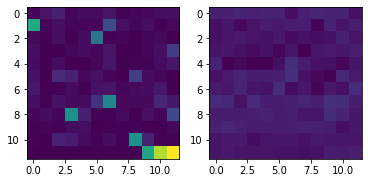

Attention sample min and max values: 2.0607244799464297e-09 | 0.09109008312225342
TOKEN IDS: [30120.0, 30120.0]
SAMPLE FROM TOKENS: [##u | ##u]


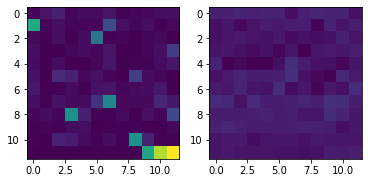

Attention sample min and max values: 4.1716865651919373e-17 | 0.7442374229431152
TOKEN IDS: [579.0, 7951.0]
SAMPLE FROM TOKENS: [- | nn]


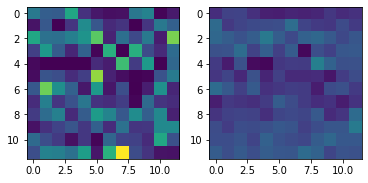

Attention sample min and max values: 1.5467353786657867e-10 | 0.9985136389732361
TOKEN IDS: [617.0, 4245.0]
SAMPLE FROM TOKENS: [only | apply]


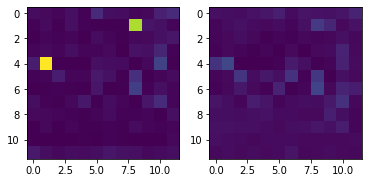

Attention sample min and max values: 9.780953243557569e-26 | 0.03080747462809086
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


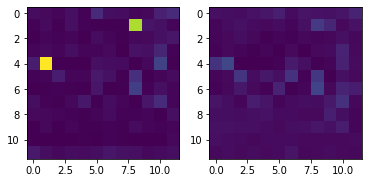

Attention sample min and max values: 1.0270629268392994e-19 | 0.6434851884841919
TOKEN IDS: [158.0, 158.0]
SAMPLE FROM TOKENS: [1 | 1]


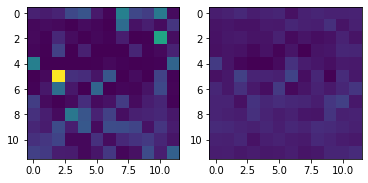

Attention sample min and max values: 6.310218558891403e-26 | 0.24470803141593933
TOKEN IDS: [796.0, 1011.0]
SAMPLE FROM TOKENS: [go | about]


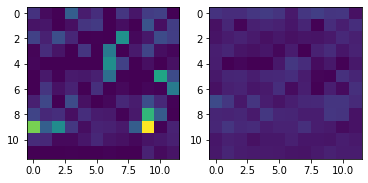

Attention sample min and max values: 3.0439176179619665e-10 | 0.21294240653514862
TOKEN IDS: [2244.0, 2244.0]
SAMPLE FROM TOKENS: [fund | fund]


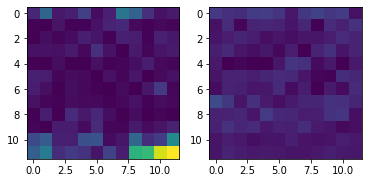

Attention sample min and max values: 7.716339868540199e-19 | 0.24202889204025269
TOKEN IDS: [6304.0, 716.0]
SAMPLE FROM TOKENS: [deb | ##lu]


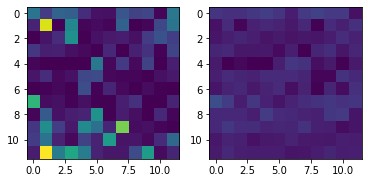

Attention sample min and max values: 1.6621957144025146e-09 | 0.5645127296447754
TOKEN IDS: [334.0, 334.0]
SAMPLE FROM TOKENS: [which | which]


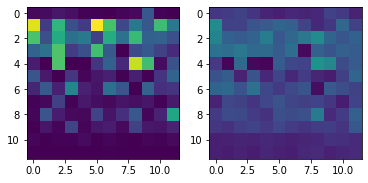

Attention sample min and max values: 6.155847745581515e-20 | 0.4814615547657013
TOKEN IDS: [121.0, 18231.0]
SAMPLE FROM TOKENS: [in | multin]


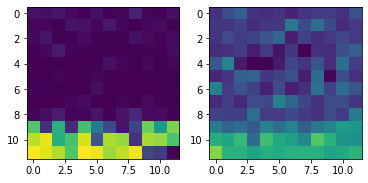

Attention sample min and max values: 2.097120713180538e-31 | 0.2598838806152344
TOKEN IDS: [10848.0, 22665.0]
SAMPLE FROM TOKENS: [poisson | intersect]


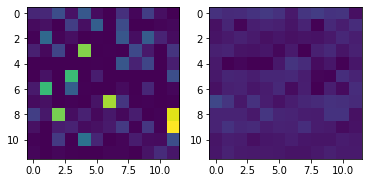

Attention sample min and max values: 1.25167510646414e-23 | 0.8500463962554932
TOKEN IDS: [546.0, 546.0]
SAMPLE FROM TOKENS: [) | )]


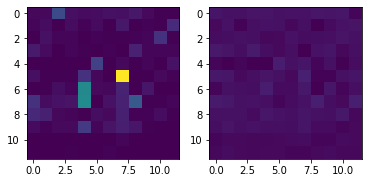

Attention sample min and max values: 7.41085017760306e-19 | 0.5707692503929138
TOKEN IDS: [106.0, 2702.0]
SAMPLE FROM TOKENS: [a | combination]


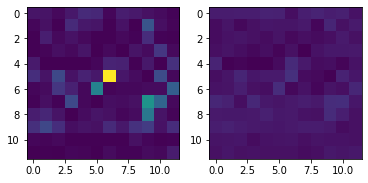

Attention sample min and max values: 1.8914519186661648e-22 | 0.31723183393478394
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


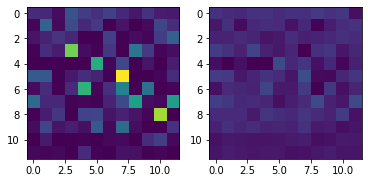

Attention sample min and max values: 1.1738371388864982e-31 | 0.1997794508934021
TOKEN IDS: [804.0, 804.0]
SAMPLE FROM TOKENS: [well | well]


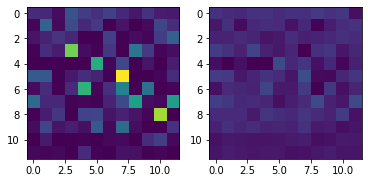

Attention sample min and max values: 1.6734197529174444e-34 | 0.03585140034556389
TOKEN IDS: [7781.0, 121.0]
SAMPLE FROM TOKENS: [neuron | in]


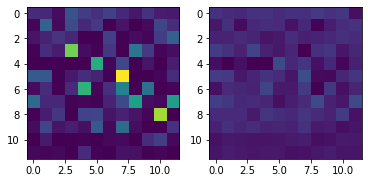

Attention sample min and max values: 1.513486580506651e-08 | 0.1962331384420395
TOKEN IDS: [6693.0, 3687.0]
SAMPLE FROM TOKENS: [artificial | neural]


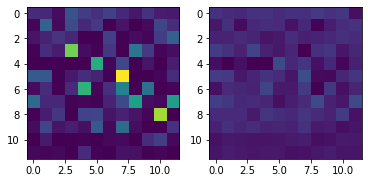

Attention sample min and max values: 2.0832708315087267e-22 | 0.37630540132522583
TOKEN IDS: [5728.0, 482.0]
SAMPLE FROM TOKENS: [adding | one]


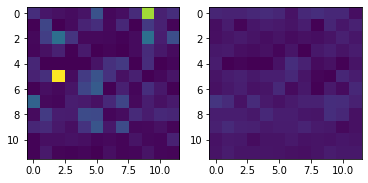

Attention sample min and max values: 2.4086750713881803e-22 | 0.18070201575756073
TOKEN IDS: [198.0, 191.0]
SAMPLE FROM TOKENS: [that | on]


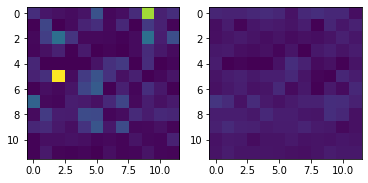

Attention sample min and max values: 9.098156251861602e-30 | 0.050578467547893524
TOKEN IDS: [3997.0, 1904.0]
SAMPLE FROM TOKENS: [machine | learning]


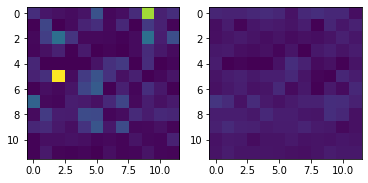

Attention sample min and max values: 4.050855831327915e-11 | 0.6639299988746643
TOKEN IDS: [121.0, 121.0]
SAMPLE FROM TOKENS: [in | in]


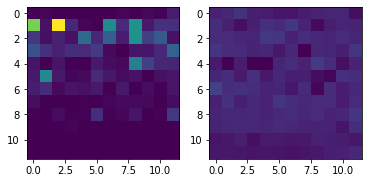

Attention sample min and max values: 2.0339354929021364e-13 | 0.10064388066530228
TOKEN IDS: [422.0, 7099.0]
SAMPLE FROM TOKENS: [, | ker]


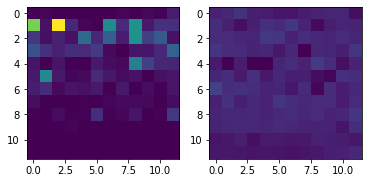

Attention sample min and max values: 2.832707332589557e-11 | 0.18716749548912048
TOKEN IDS: [20020.0, 20020.0]
SAMPLE FROM TOKENS: [maximizes | maximizes]


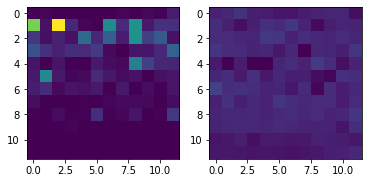

Attention sample min and max values: 2.643814334124528e-10 | 0.9998255372047424
TOKEN IDS: [112.0, 111.0]
SAMPLE FROM TOKENS: [s | the]


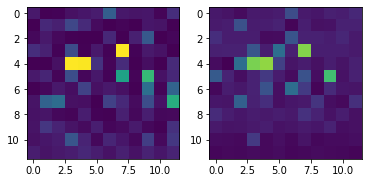

Attention sample min and max values: 2.675495619470429e-28 | 0.1656353771686554
TOKEN IDS: [2810.0, 214.0]
SAMPLE FROM TOKENS: [supported | by]


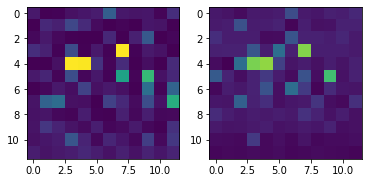

Attention sample min and max values: 1.147657539849942e-15 | 0.6193265318870544
TOKEN IDS: [4043.0, 3912.0]
SAMPLE FROM TOKENS: [enough | ?]


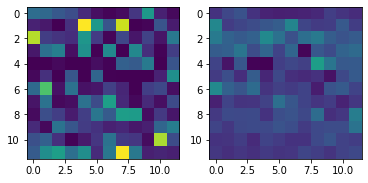

Attention sample min and max values: 1.5962877751059166e-26 | 0.9092662930488586
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


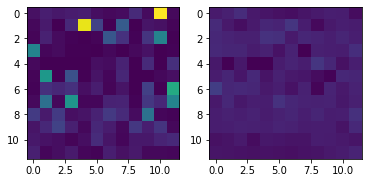

Attention sample min and max values: 2.3457429826993593e-24 | 0.12749235332012177
TOKEN IDS: [195.0, 501.0]
SAMPLE FROM TOKENS: [be | used]


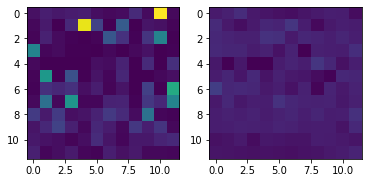

Attention sample min and max values: 1.2300873440356971e-21 | 0.38683730363845825
TOKEN IDS: [546.0, 422.0]
SAMPLE FROM TOKENS: [) | ,]


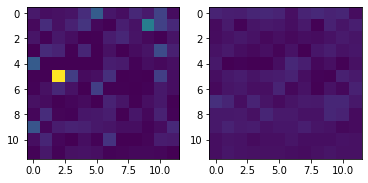

Attention sample min and max values: 8.69303561019984e-15 | 0.14509789645671844
TOKEN IDS: [111.0, 649.0]
SAMPLE FROM TOKENS: [the | number]


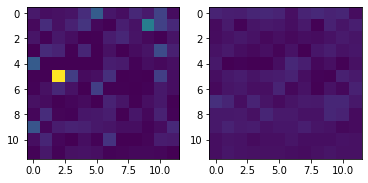

Attention sample min and max values: 2.543975642357121e-24 | 0.08704203367233276
TOKEN IDS: [3512.0, 2048.0]
SAMPLE FROM TOKENS: [recognition | technology]


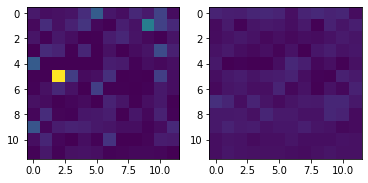

Attention sample min and max values: 6.100146178614018e-20 | 0.024141065776348114
TOKEN IDS: [422.0, 422.0]
SAMPLE FROM TOKENS: [, | ,]


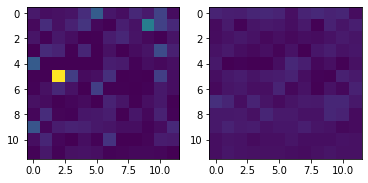

Attention sample min and max values: 5.731078999815509e-06 | 0.791650116443634
TOKEN IDS: [30120.0, 30120.0]
SAMPLE FROM TOKENS: [##u | ##u]


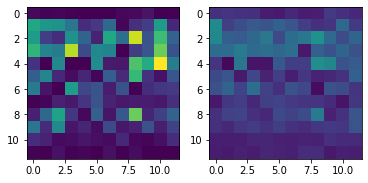

Attention sample min and max values: 3.2628662813359754e-22 | 0.03160766884684563
TOKEN IDS: [579.0, 7951.0]
SAMPLE FROM TOKENS: [- | nn]


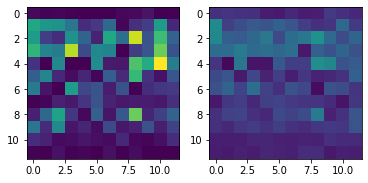

Attention sample min and max values: 3.245671641996022e-19 | 0.02281557396054268
TOKEN IDS: [617.0, 4245.0]
SAMPLE FROM TOKENS: [only | apply]


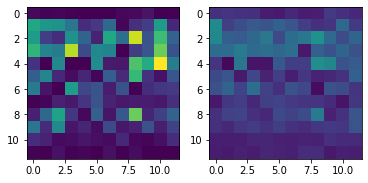

Attention sample min and max values: 1.5758905684581662e-24 | 0.3443371653556824
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


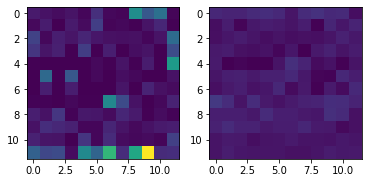

Attention sample min and max values: 4.205663610335643e-22 | 0.9831339120864868
TOKEN IDS: [158.0, 158.0]
SAMPLE FROM TOKENS: [1 | 1]


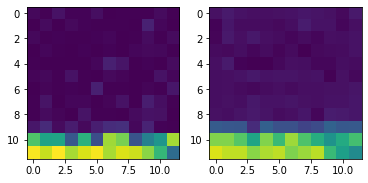

Attention sample min and max values: 1.6663027224694815e-07 | 0.45243093371391296
TOKEN IDS: [796.0, 1011.0]
SAMPLE FROM TOKENS: [go | about]


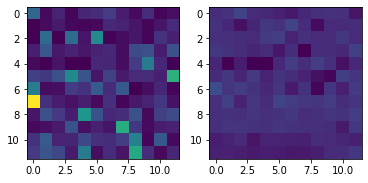

Attention sample min and max values: 1.0286096382625e-18 | 0.7557718753814697
TOKEN IDS: [2244.0, 2244.0]
SAMPLE FROM TOKENS: [fund | fund]


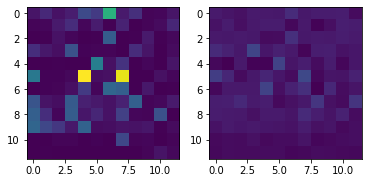

Attention sample min and max values: 2.691107470296476e-23 | 0.9981514811515808
TOKEN IDS: [6304.0, 716.0]
SAMPLE FROM TOKENS: [deb | ##lu]


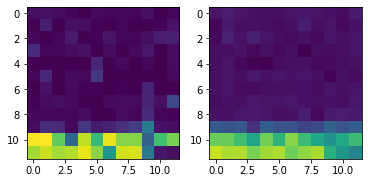

Attention sample min and max values: 2.7187192652196584e-35 | 0.7905007600784302
TOKEN IDS: [334.0, 334.0]
SAMPLE FROM TOKENS: [which | which]


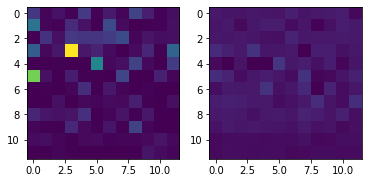

Attention sample min and max values: 1.1843104399033184e-22 | 0.1836242973804474
TOKEN IDS: [121.0, 18231.0]
SAMPLE FROM TOKENS: [in | multin]


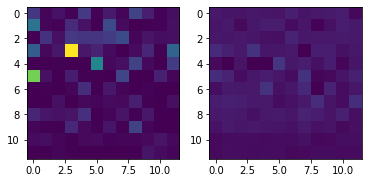

Attention sample min and max values: 3.334766095193089e-32 | 0.1265413910150528
TOKEN IDS: [10848.0, 22665.0]
SAMPLE FROM TOKENS: [poisson | intersect]


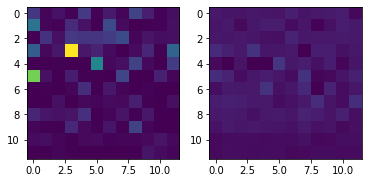

Attention sample min and max values: 3.171853404926317e-11 | 0.5612437725067139
TOKEN IDS: [546.0, 546.0]
SAMPLE FROM TOKENS: [) | )]


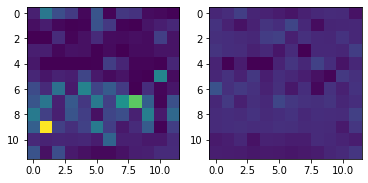

Attention sample min and max values: 6.632706006281401e-25 | 0.18559885025024414
TOKEN IDS: [106.0, 2702.0]
SAMPLE FROM TOKENS: [a | combination]


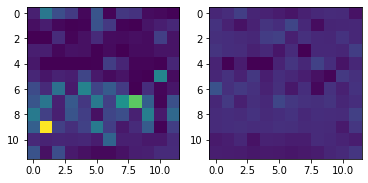

Attention sample min and max values: 3.808924731174557e-09 | 0.08241460472345352
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


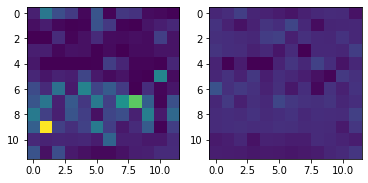

Attention sample min and max values: 1.361386047296631e-13 | 0.1108427569270134
TOKEN IDS: [804.0, 804.0]
SAMPLE FROM TOKENS: [well | well]


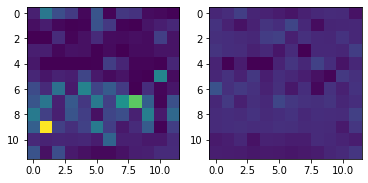

Attention sample min and max values: 8.39688633294031e-24 | 0.3568587601184845
TOKEN IDS: [7781.0, 121.0]
SAMPLE FROM TOKENS: [neuron | in]


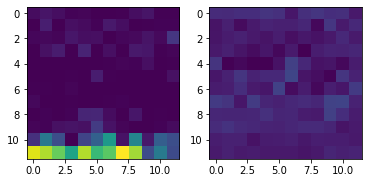

Attention sample min and max values: 9.03917862160597e-06 | 0.9408035278320312
TOKEN IDS: [6693.0, 3687.0]
SAMPLE FROM TOKENS: [artificial | neural]


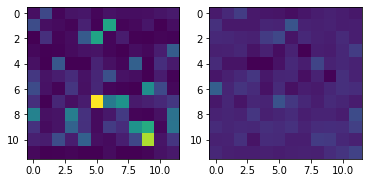

Attention sample min and max values: 9.849329380313545e-20 | 0.06597927212715149
TOKEN IDS: [5728.0, 482.0]
SAMPLE FROM TOKENS: [adding | one]


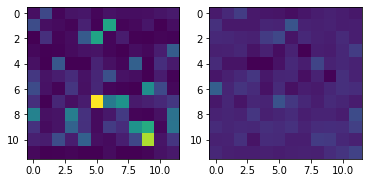

Attention sample min and max values: 2.4515436555794246e-11 | 0.7361873388290405
TOKEN IDS: [198.0, 191.0]
SAMPLE FROM TOKENS: [that | on]


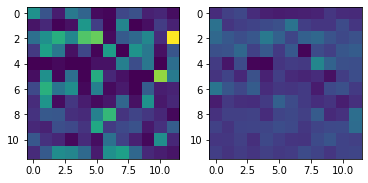

Attention sample min and max values: 1.390640380627417e-10 | 0.14817391335964203
TOKEN IDS: [3997.0, 1904.0]
SAMPLE FROM TOKENS: [machine | learning]


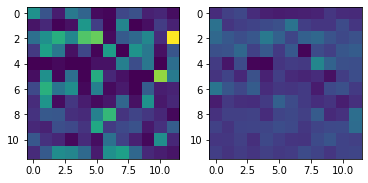

Attention sample min and max values: 1.0661783625762702e-36 | 0.04072074219584465
TOKEN IDS: [121.0, 121.0]
SAMPLE FROM TOKENS: [in | in]


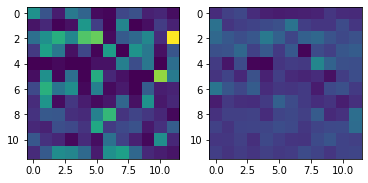

Attention sample min and max values: 1.2499874419769682e-14 | 0.9607822299003601
TOKEN IDS: [422.0, 7099.0]
SAMPLE FROM TOKENS: [, | ker]


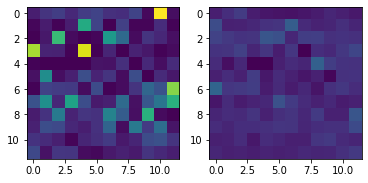

Attention sample min and max values: 6.865668435012686e-16 | 0.15119199454784393
TOKEN IDS: [20020.0, 20020.0]
SAMPLE FROM TOKENS: [maximizes | maximizes]


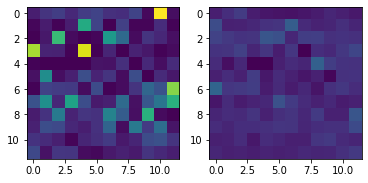

Attention sample min and max values: 2.1786980099269918e-22 | 0.42238539457321167
TOKEN IDS: [112.0, 111.0]
SAMPLE FROM TOKENS: [s | the]


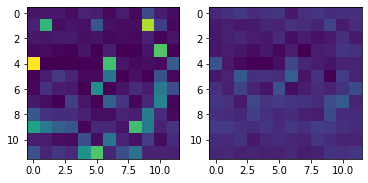

Attention sample min and max values: 9.797744837669597e-09 | 0.3571135401725769
TOKEN IDS: [2810.0, 214.0]
SAMPLE FROM TOKENS: [supported | by]


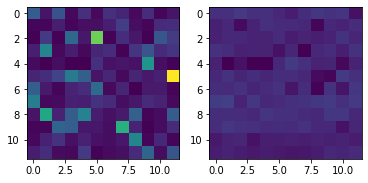

Attention sample min and max values: 3.4837935620469046e-24 | 0.42153486609458923
TOKEN IDS: [4043.0, 3912.0]
SAMPLE FROM TOKENS: [enough | ?]


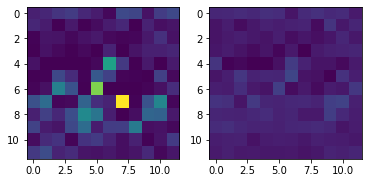

Attention sample min and max values: 1.30390127615131e-28 | 0.0727296993136406
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


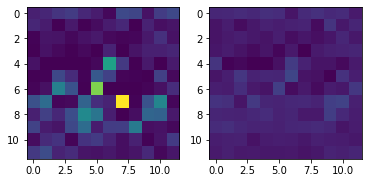

Attention sample min and max values: 2.5016110507335845e-26 | 0.18279018998146057
TOKEN IDS: [195.0, 501.0]
SAMPLE FROM TOKENS: [be | used]


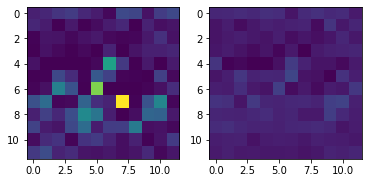

Attention sample min and max values: 8.631974099540859e-27 | 0.29010331630706787
TOKEN IDS: [546.0, 422.0]
SAMPLE FROM TOKENS: [) | ,]


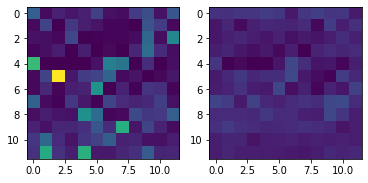

Attention sample min and max values: 1.1527219722350267e-23 | 0.25386521220207214
TOKEN IDS: [111.0, 649.0]
SAMPLE FROM TOKENS: [the | number]


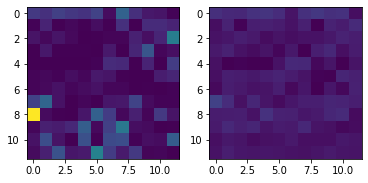

Attention sample min and max values: 9.48594718400142e-13 | 0.18926332890987396
TOKEN IDS: [3512.0, 2048.0]
SAMPLE FROM TOKENS: [recognition | technology]


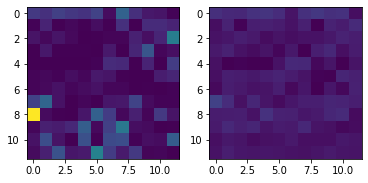

Attention sample min and max values: 2.123110985435976e-28 | 0.10957248508930206
TOKEN IDS: [422.0, 422.0]
SAMPLE FROM TOKENS: [, | ,]


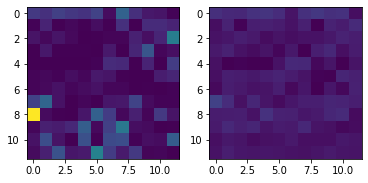

Attention sample min and max values: 7.213956484763568e-34 | 0.03906957805156708
TOKEN IDS: [30120.0, 30120.0]
SAMPLE FROM TOKENS: [##u | ##u]


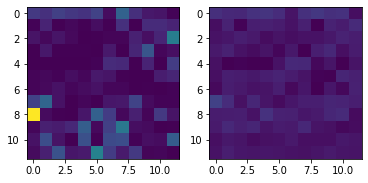

Attention sample min and max values: 2.62414584826327e-14 | 0.25989770889282227
TOKEN IDS: [579.0, 7951.0]
SAMPLE FROM TOKENS: [- | nn]


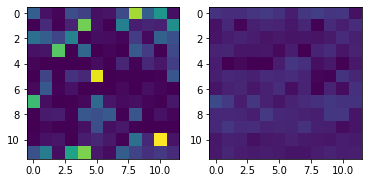

Attention sample min and max values: 3.565347974580916e-24 | 0.21339190006256104
TOKEN IDS: [617.0, 4245.0]
SAMPLE FROM TOKENS: [only | apply]


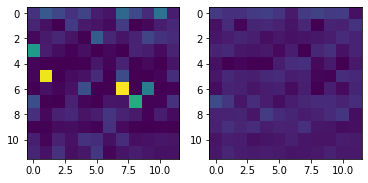

Attention sample min and max values: 1.2735602467728313e-05 | 0.6577785611152649
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


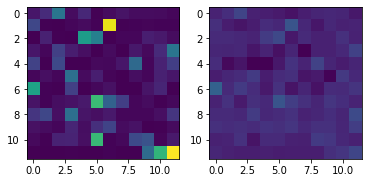

Attention sample min and max values: 4.2558632399464225e-13 | 0.0785754919052124
TOKEN IDS: [158.0, 158.0]
SAMPLE FROM TOKENS: [1 | 1]


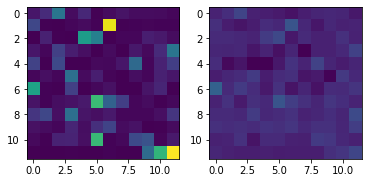

Attention sample min and max values: 1.7761935134429948e-27 | 0.1876605600118637
TOKEN IDS: [796.0, 1011.0]
SAMPLE FROM TOKENS: [go | about]


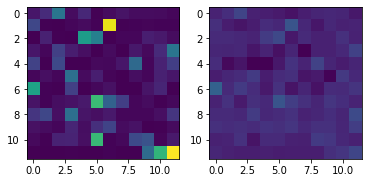

Attention sample min and max values: 6.257450984606315e-37 | 0.30662962794303894
TOKEN IDS: [2244.0, 2244.0]
SAMPLE FROM TOKENS: [fund | fund]


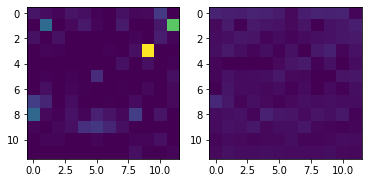

Attention sample min and max values: 8.187905404005867e-23 | 0.20953381061553955
TOKEN IDS: [6304.0, 716.0]
SAMPLE FROM TOKENS: [deb | ##lu]


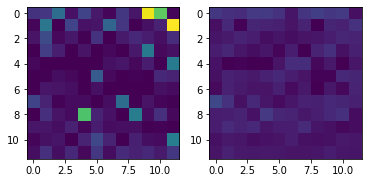

Attention sample min and max values: 4.6250121787938525e-11 | 0.08328605443239212
TOKEN IDS: [334.0, 334.0]
SAMPLE FROM TOKENS: [which | which]


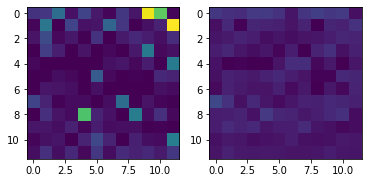

Attention sample min and max values: 1.5433273691141391e-13 | 0.999996542930603
TOKEN IDS: [121.0, 18231.0]
SAMPLE FROM TOKENS: [in | multin]


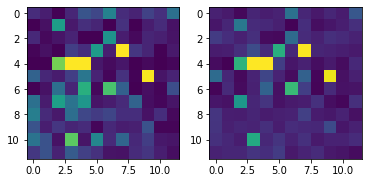

Attention sample min and max values: 9.648053846854985e-25 | 0.07605962455272675
TOKEN IDS: [10848.0, 22665.0]
SAMPLE FROM TOKENS: [poisson | intersect]


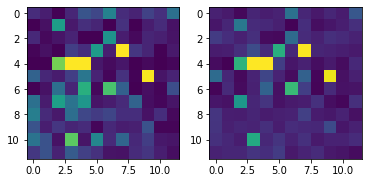

Attention sample min and max values: 3.4582549362149537e-14 | 0.04546332731842995
TOKEN IDS: [546.0, 546.0]
SAMPLE FROM TOKENS: [) | )]


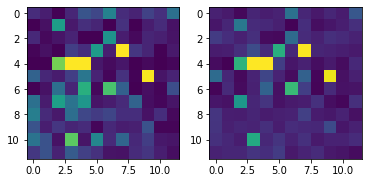

Attention sample min and max values: 3.7429622630405776e-26 | 0.11533970385789871
TOKEN IDS: [106.0, 2702.0]
SAMPLE FROM TOKENS: [a | combination]


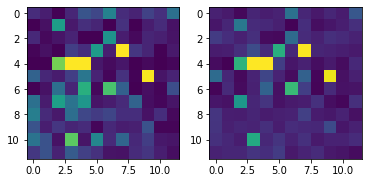

Attention sample min and max values: 4.013264960970766e-32 | 0.0473797544836998
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


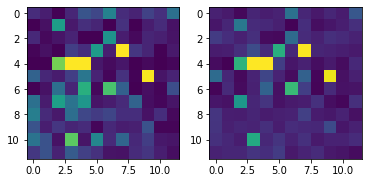

Attention sample min and max values: 1.6259834370992313e-22 | 0.23369964957237244
TOKEN IDS: [804.0, 804.0]
SAMPLE FROM TOKENS: [well | well]


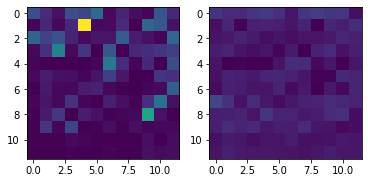

Attention sample min and max values: 1.1639631480875323e-08 | 0.9190332293510437
TOKEN IDS: [7781.0, 121.0]
SAMPLE FROM TOKENS: [neuron | in]


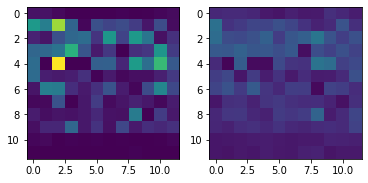

Attention sample min and max values: 1.5270922086753816e-17 | 0.041410431265830994
TOKEN IDS: [6693.0, 3687.0]
SAMPLE FROM TOKENS: [artificial | neural]


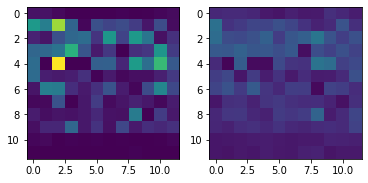

Attention sample min and max values: 1.7231283360827246e-15 | 0.21436356008052826
TOKEN IDS: [5728.0, 482.0]
SAMPLE FROM TOKENS: [adding | one]


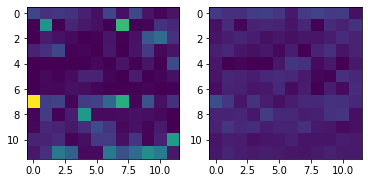

Attention sample min and max values: 2.5634265144472386e-19 | 0.36266660690307617
TOKEN IDS: [198.0, 191.0]
SAMPLE FROM TOKENS: [that | on]


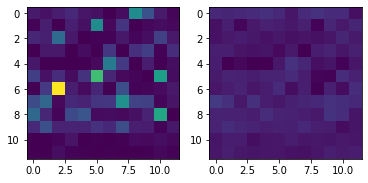

Attention sample min and max values: 3.063789456511645e-13 | 0.2080712765455246
TOKEN IDS: [3997.0, 1904.0]
SAMPLE FROM TOKENS: [machine | learning]


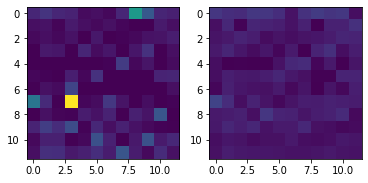

Attention sample min and max values: 1.9847515991822107e-11 | 0.9999905824661255
TOKEN IDS: [121.0, 121.0]
SAMPLE FROM TOKENS: [in | in]


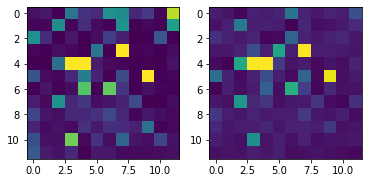

Attention sample min and max values: 5.202251486480236e-06 | 0.5665789246559143
TOKEN IDS: [422.0, 7099.0]
SAMPLE FROM TOKENS: [, | ker]


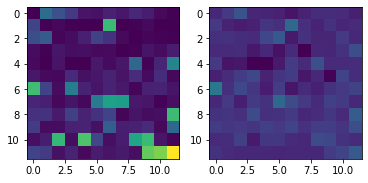

Attention sample min and max values: 3.705059330627765e-15 | 0.19683505594730377
TOKEN IDS: [20020.0, 20020.0]
SAMPLE FROM TOKENS: [maximizes | maximizes]


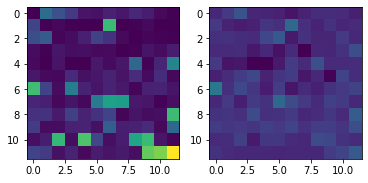

Attention sample min and max values: 3.5915654131302155e-12 | 0.5730921030044556
TOKEN IDS: [112.0, 111.0]
SAMPLE FROM TOKENS: [s | the]


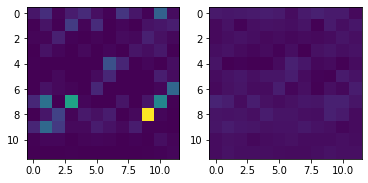

Attention sample min and max values: 2.0002147507747203e-11 | 0.9999955892562866
TOKEN IDS: [2810.0, 214.0]
SAMPLE FROM TOKENS: [supported | by]


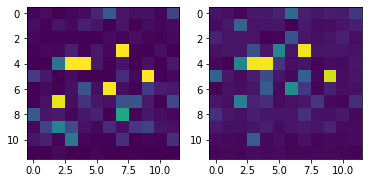

Attention sample min and max values: 1.2408452931822467e-08 | 0.6795797944068909
TOKEN IDS: [4043.0, 3912.0]
SAMPLE FROM TOKENS: [enough | ?]


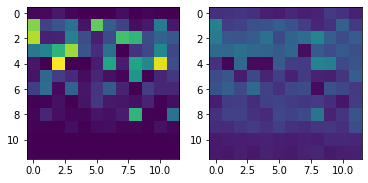

Attention sample min and max values: 5.188711017851846e-16 | 0.10093829780817032
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


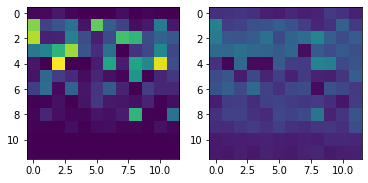

Attention sample min and max values: 1.4128266698915093e-12 | 0.9996336698532104
TOKEN IDS: [195.0, 501.0]
SAMPLE FROM TOKENS: [be | used]


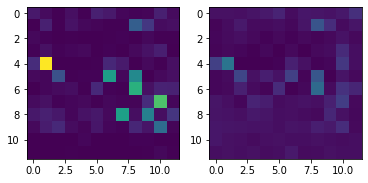

Attention sample min and max values: 5.158063614174297e-28 | 0.06879383325576782
TOKEN IDS: [546.0, 422.0]
SAMPLE FROM TOKENS: [) | ,]


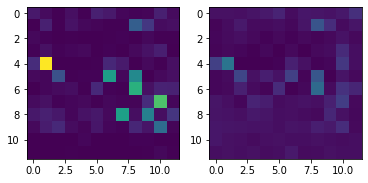

Attention sample min and max values: 2.4629151122165606e-26 | 0.39816248416900635
TOKEN IDS: [111.0, 649.0]
SAMPLE FROM TOKENS: [the | number]


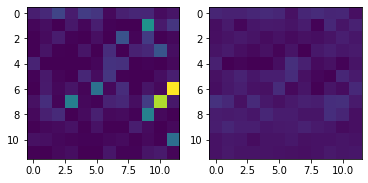

Attention sample min and max values: 1.708505527635193e-20 | 0.13557851314544678
TOKEN IDS: [3512.0, 2048.0]
SAMPLE FROM TOKENS: [recognition | technology]


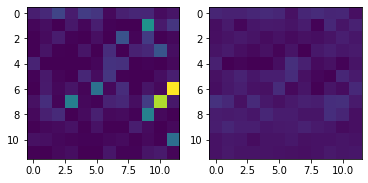

Attention sample min and max values: 2.1151395251158694e-15 | 0.9909226298332214
TOKEN IDS: [422.0, 422.0]
SAMPLE FROM TOKENS: [, | ,]


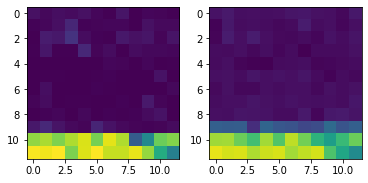

Attention sample min and max values: 8.706267232331586e-27 | 0.9282962083816528
TOKEN IDS: [30120.0, 30120.0]
SAMPLE FROM TOKENS: [##u | ##u]


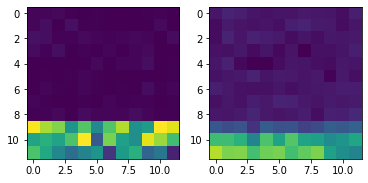

Attention sample min and max values: 2.8011628753859244e-19 | 0.05816749483346939
TOKEN IDS: [579.0, 7951.0]
SAMPLE FROM TOKENS: [- | nn]


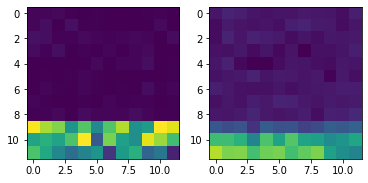

Attention sample min and max values: 2.6477922362832344e-37 | 0.0792657658457756
TOKEN IDS: [617.0, 4245.0]
SAMPLE FROM TOKENS: [only | apply]


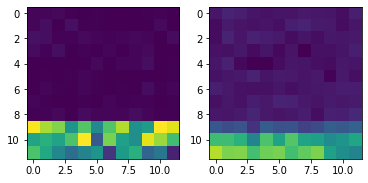

Attention sample min and max values: 1.8832156770229882e-29 | 0.05587496981024742
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


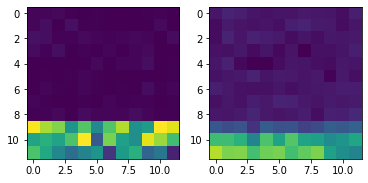

Attention sample min and max values: 9.019725938631223e-24 | 0.19080884754657745
TOKEN IDS: [158.0, 158.0]
SAMPLE FROM TOKENS: [1 | 1]


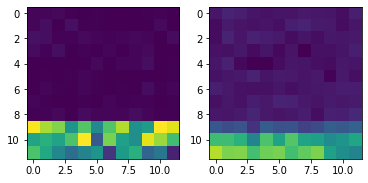

Attention sample min and max values: 1.5283313893957318e-12 | 0.31259915232658386
TOKEN IDS: [796.0, 1011.0]
SAMPLE FROM TOKENS: [go | about]


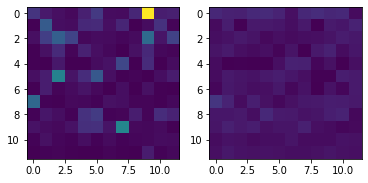

Attention sample min and max values: 1.3526187819540986e-13 | 0.3451634645462036
TOKEN IDS: [2244.0, 2244.0]
SAMPLE FROM TOKENS: [fund | fund]


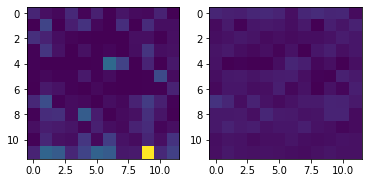

Attention sample min and max values: 3.7055053780932212e-06 | 0.9924874305725098
TOKEN IDS: [6304.0, 716.0]
SAMPLE FROM TOKENS: [deb | ##lu]


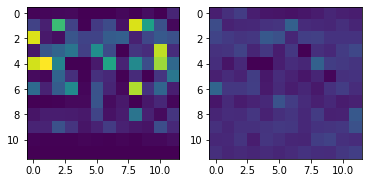

Attention sample min and max values: 1.589220291822735e-12 | 0.9999233484268188
TOKEN IDS: [334.0, 334.0]
SAMPLE FROM TOKENS: [which | which]


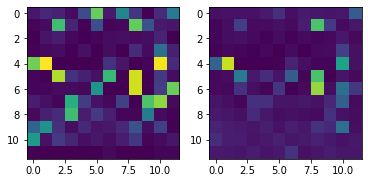

Attention sample min and max values: 2.6309526389087234e-13 | 0.1638088822364807
TOKEN IDS: [121.0, 18231.0]
SAMPLE FROM TOKENS: [in | multin]


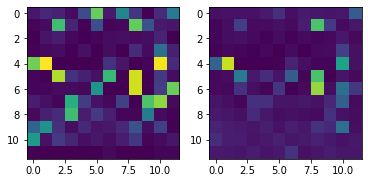

Attention sample min and max values: 1.3592946509520597e-17 | 0.50936359167099
TOKEN IDS: [10848.0, 22665.0]
SAMPLE FROM TOKENS: [poisson | intersect]


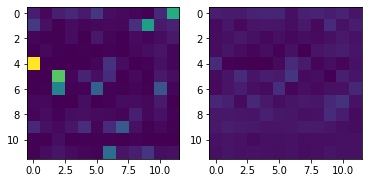

Attention sample min and max values: 6.059869729574505e-25 | 0.2751428782939911
TOKEN IDS: [546.0, 546.0]
SAMPLE FROM TOKENS: [) | )]


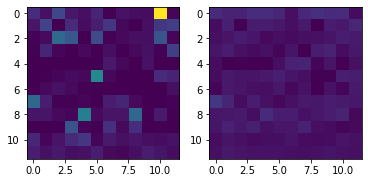

Attention sample min and max values: 2.09991994779557e-05 | 0.608180582523346
TOKEN IDS: [106.0, 2702.0]
SAMPLE FROM TOKENS: [a | combination]


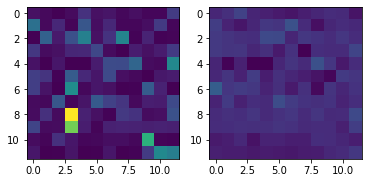

Attention sample min and max values: 4.713089727520492e-12 | 0.9998972415924072
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


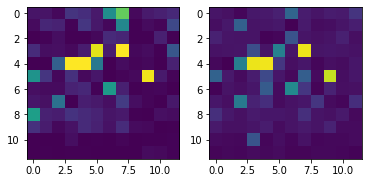

Attention sample min and max values: 3.0124819739435482e-12 | 0.3845019042491913
TOKEN IDS: [804.0, 804.0]
SAMPLE FROM TOKENS: [well | well]


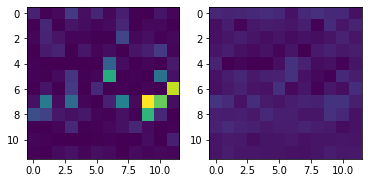

Attention sample min and max values: 1.4624811723878952e-21 | 0.37637707591056824
TOKEN IDS: [7781.0, 121.0]
SAMPLE FROM TOKENS: [neuron | in]


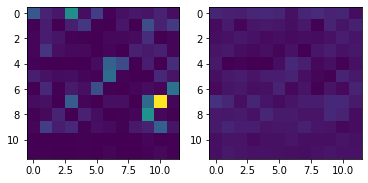

Attention sample min and max values: 1.2958475438529238e-12 | 0.999974250793457
TOKEN IDS: [6693.0, 3687.0]
SAMPLE FROM TOKENS: [artificial | neural]


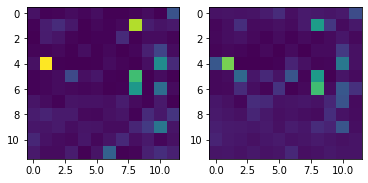

Attention sample min and max values: 3.630047269469613e-23 | 0.12429993599653244
TOKEN IDS: [5728.0, 482.0]
SAMPLE FROM TOKENS: [adding | one]


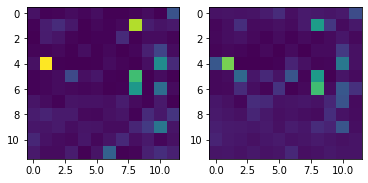

Attention sample min and max values: 2.745801434746552e-18 | 0.8142848014831543
TOKEN IDS: [198.0, 191.0]
SAMPLE FROM TOKENS: [that | on]


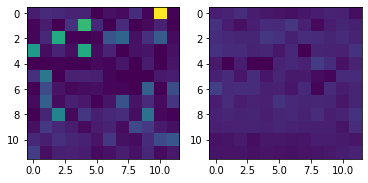

Attention sample min and max values: 2.2881848353779574e-22 | 0.9958553910255432
TOKEN IDS: [3997.0, 1904.0]
SAMPLE FROM TOKENS: [machine | learning]


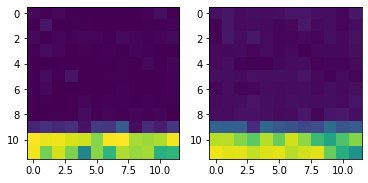

Attention sample min and max values: 1.476117223279136e-15 | 0.48992472887039185
TOKEN IDS: [121.0, 121.0]
SAMPLE FROM TOKENS: [in | in]


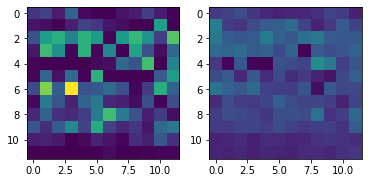

Attention sample min and max values: 6.809550384674721e-16 | 0.9999954700469971
TOKEN IDS: [422.0, 7099.0]
SAMPLE FROM TOKENS: [, | ker]


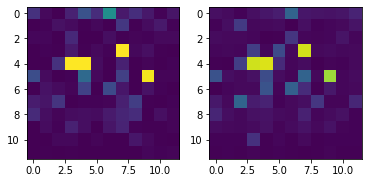

Attention sample min and max values: 4.1698036690185347e-10 | 0.6632611751556396
TOKEN IDS: [20020.0, 20020.0]
SAMPLE FROM TOKENS: [maximizes | maximizes]


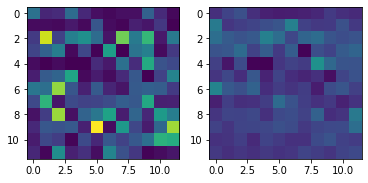

Attention sample min and max values: 1.9104422806820593e-17 | 0.1076756939291954
TOKEN IDS: [112.0, 111.0]
SAMPLE FROM TOKENS: [s | the]


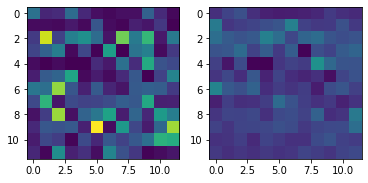

Attention sample min and max values: 8.953714058082329e-24 | 0.8648134469985962
TOKEN IDS: [2810.0, 214.0]
SAMPLE FROM TOKENS: [supported | by]


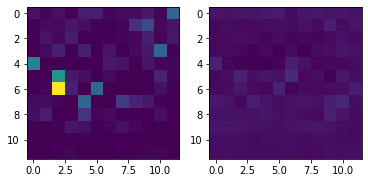

Attention sample min and max values: 2.4161017333550543e-25 | 0.013919807970523834
TOKEN IDS: [4043.0, 3912.0]
SAMPLE FROM TOKENS: [enough | ?]


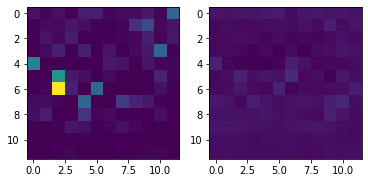

Attention sample min and max values: 9.293376640743623e-32 | 0.05079849436879158
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


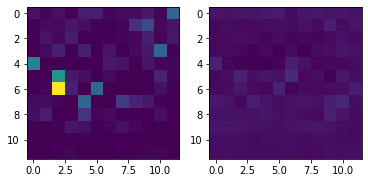

Attention sample min and max values: 1.5124145404536728e-23 | 0.17727471888065338
TOKEN IDS: [195.0, 501.0]
SAMPLE FROM TOKENS: [be | used]


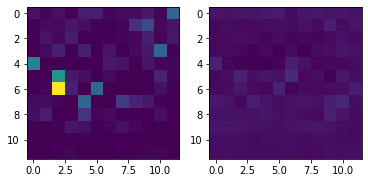

Attention sample min and max values: 8.920443839505123e-16 | 1.0
TOKEN IDS: [546.0, 422.0]
SAMPLE FROM TOKENS: [) | ,]


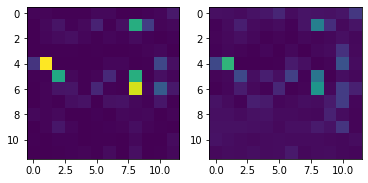

Attention sample min and max values: 2.349944946089083e-16 | 0.28151240944862366
TOKEN IDS: [111.0, 649.0]
SAMPLE FROM TOKENS: [the | number]


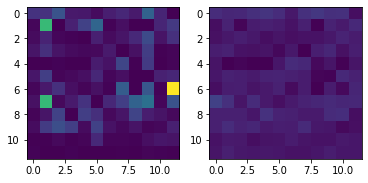

Attention sample min and max values: 1.520101374446451e-17 | 0.47429412603378296
TOKEN IDS: [3512.0, 2048.0]
SAMPLE FROM TOKENS: [recognition | technology]


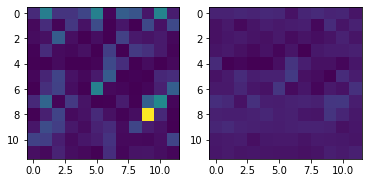

Attention sample min and max values: 6.751368238581782e-23 | 0.0823458880186081
TOKEN IDS: [422.0, 422.0]
SAMPLE FROM TOKENS: [, | ,]


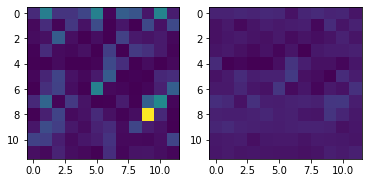

Attention sample min and max values: 8.129657537436774e-12 | 0.059881385415792465
TOKEN IDS: [30120.0, 30120.0]
SAMPLE FROM TOKENS: [##u | ##u]


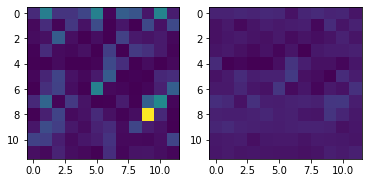

Attention sample min and max values: 3.252858728783469e-22 | 0.24450820684432983
TOKEN IDS: [579.0, 7951.0]
SAMPLE FROM TOKENS: [- | nn]


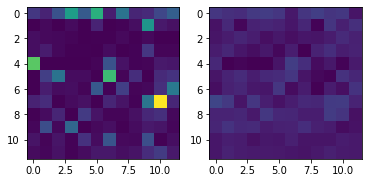

Attention sample min and max values: 6.962802499687914e-20 | 0.2785271406173706
TOKEN IDS: [617.0, 4245.0]
SAMPLE FROM TOKENS: [only | apply]


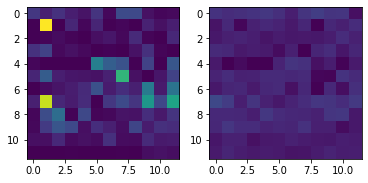

Attention sample min and max values: 1.5552359330031867e-18 | 0.7541759610176086
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


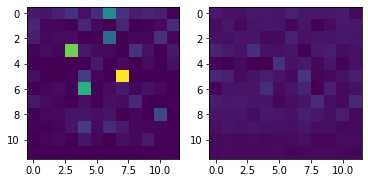

Attention sample min and max values: 7.028594125933335e-26 | 0.2627151608467102
TOKEN IDS: [158.0, 158.0]
SAMPLE FROM TOKENS: [1 | 1]


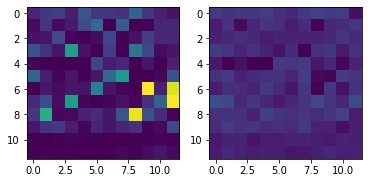

Attention sample min and max values: 9.37036498689892e-22 | 0.018623296171426773
TOKEN IDS: [796.0, 1011.0]
SAMPLE FROM TOKENS: [go | about]


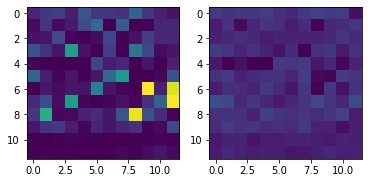

Attention sample min and max values: 5.149498449197857e-23 | 0.8451666831970215
TOKEN IDS: [2244.0, 2244.0]
SAMPLE FROM TOKENS: [fund | fund]


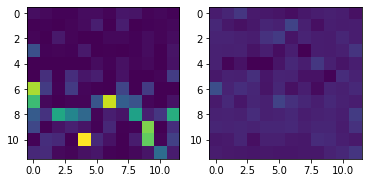

Attention sample min and max values: 7.626051967690728e-08 | 0.7146125435829163
TOKEN IDS: [6304.0, 716.0]
SAMPLE FROM TOKENS: [deb | ##lu]


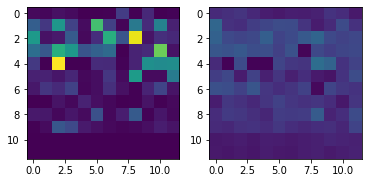

Attention sample min and max values: 4.734488160011876e-27 | 0.06498115509748459
TOKEN IDS: [334.0, 334.0]
SAMPLE FROM TOKENS: [which | which]


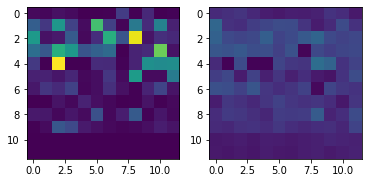

Attention sample min and max values: 2.4289360623764667e-16 | 0.08640803396701813
TOKEN IDS: [121.0, 18231.0]
SAMPLE FROM TOKENS: [in | multin]


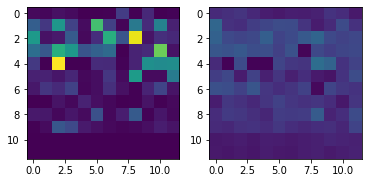

Attention sample min and max values: 3.459108409218226e-20 | 0.9078654050827026
TOKEN IDS: [10848.0, 22665.0]
SAMPLE FROM TOKENS: [poisson | intersect]


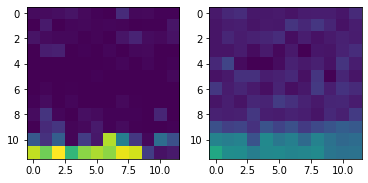

Attention sample min and max values: 6.74498217605119e-21 | 0.05295255407691002
TOKEN IDS: [546.0, 546.0]
SAMPLE FROM TOKENS: [) | )]


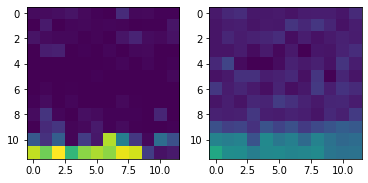

Attention sample min and max values: 1.2111155863639301e-23 | 0.3575323224067688
TOKEN IDS: [106.0, 2702.0]
SAMPLE FROM TOKENS: [a | combination]


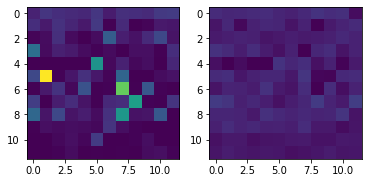

Attention sample min and max values: 9.319226640380762e-11 | 0.6429367065429688
TOKEN IDS: [103.0, 103.0]
SAMPLE FROM TOKENS: [[SEP] | [SEP]]


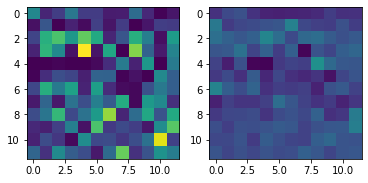

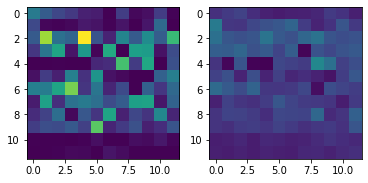

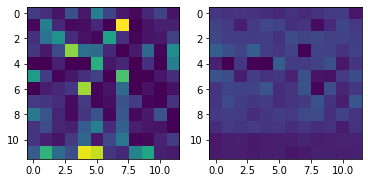

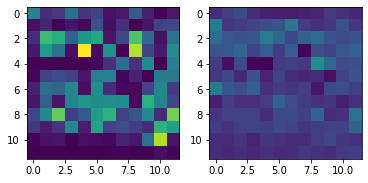

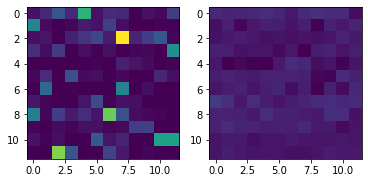

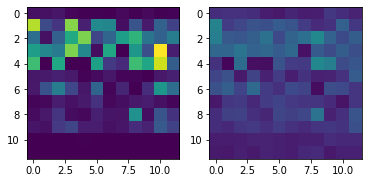

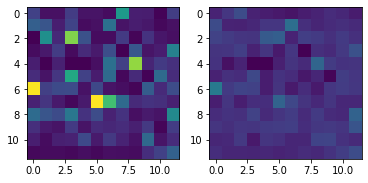

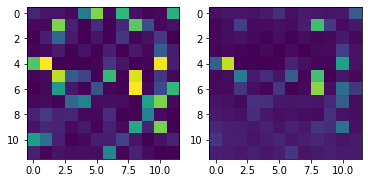

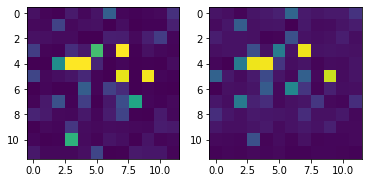

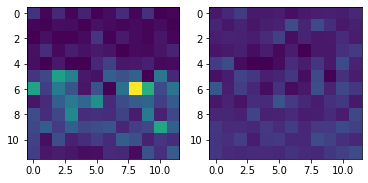

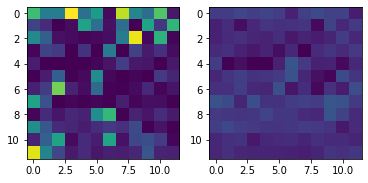

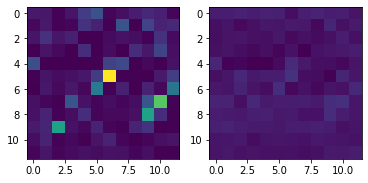

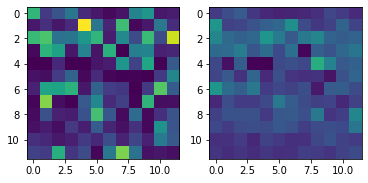

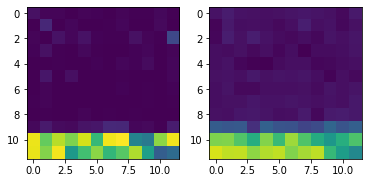

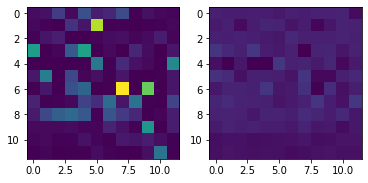

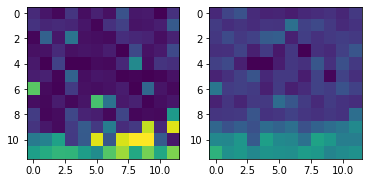

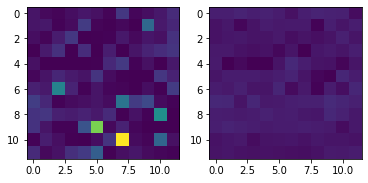

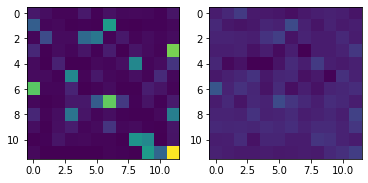

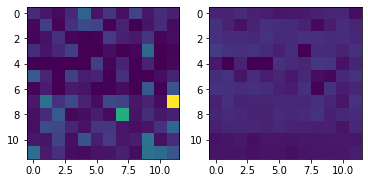

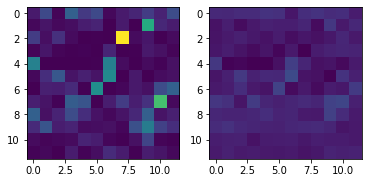

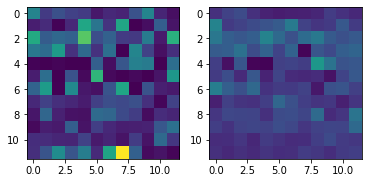

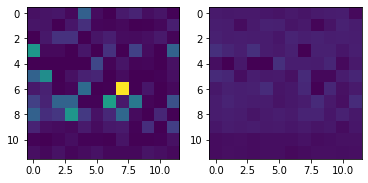

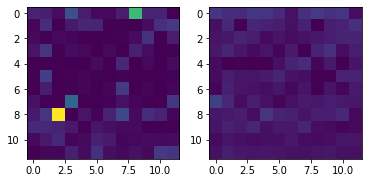

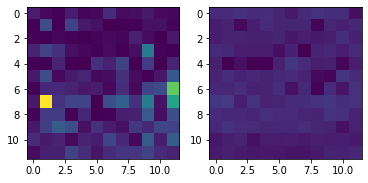

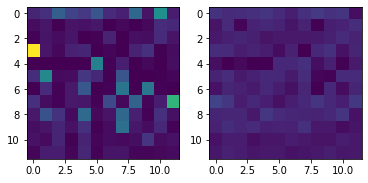

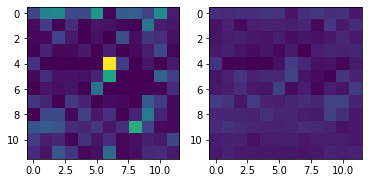

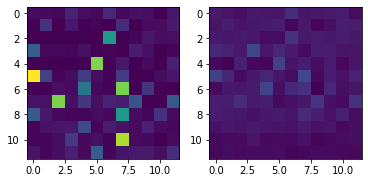

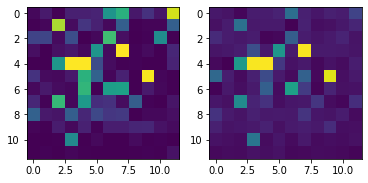

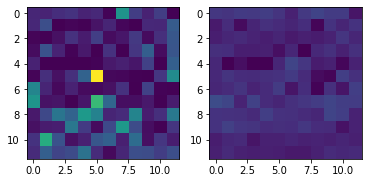

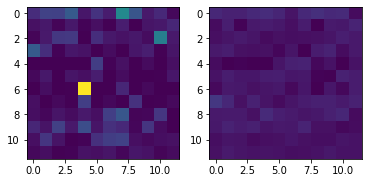

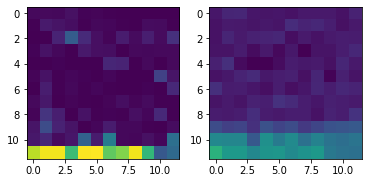

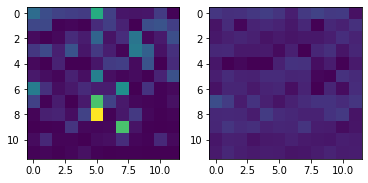

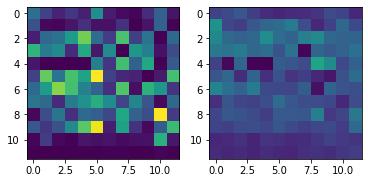

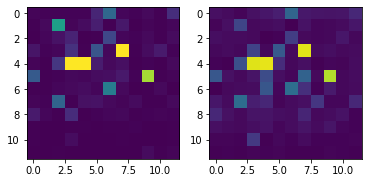

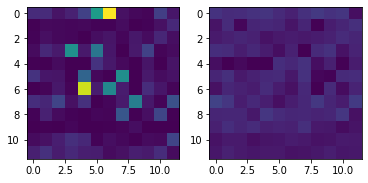

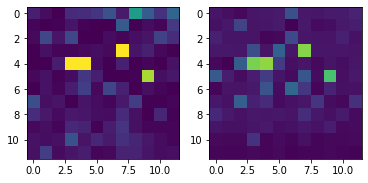

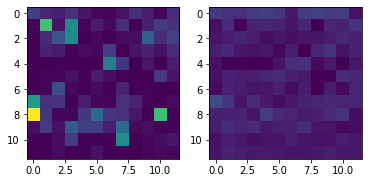

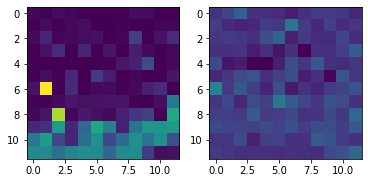

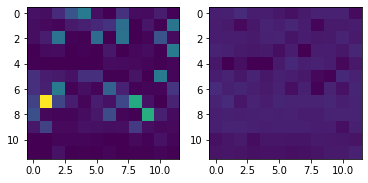

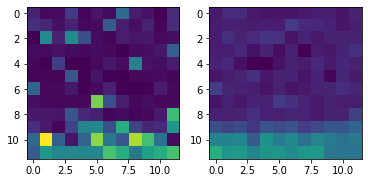

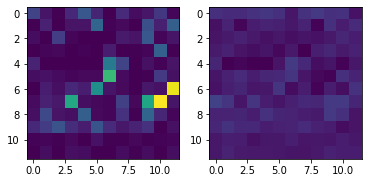

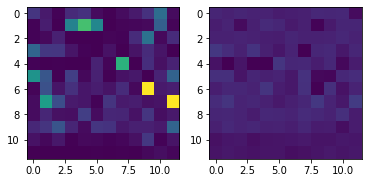

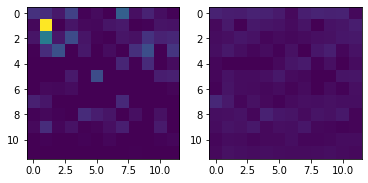

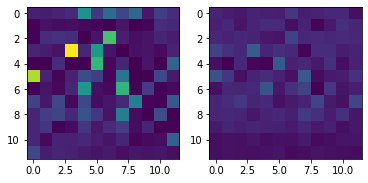

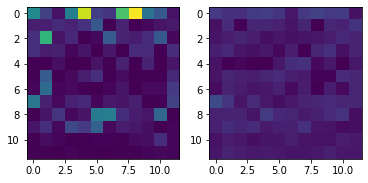

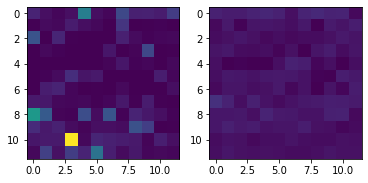

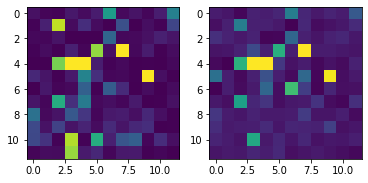

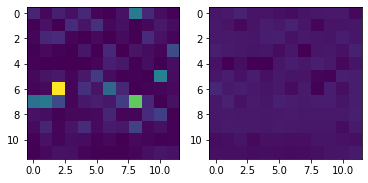

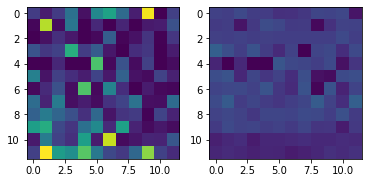

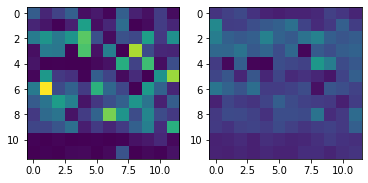

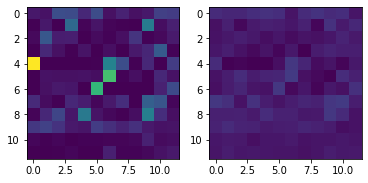

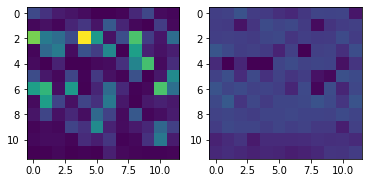

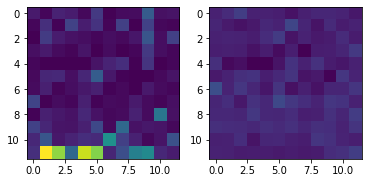

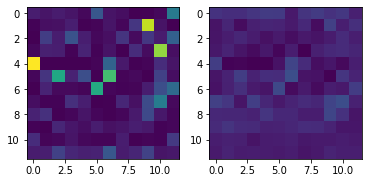

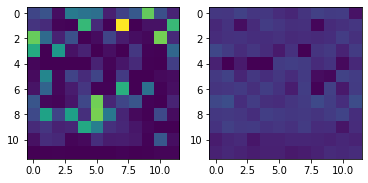

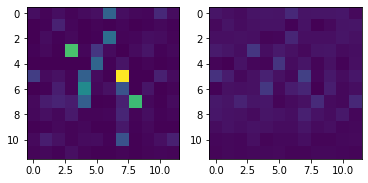

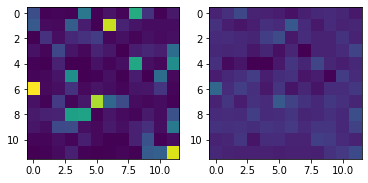

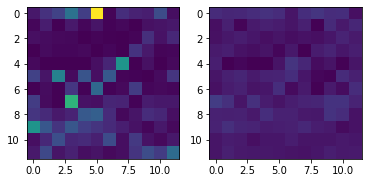

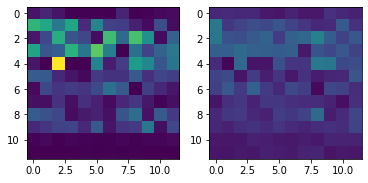

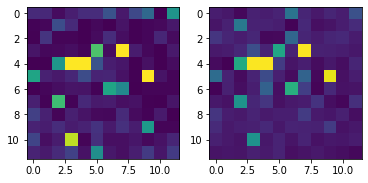

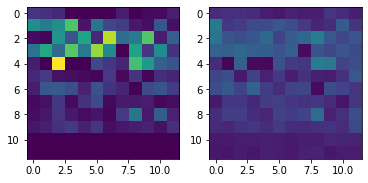

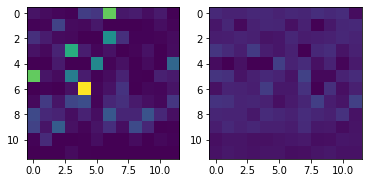

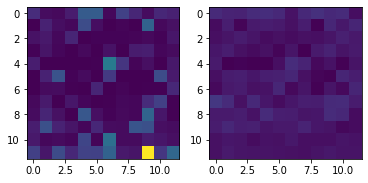

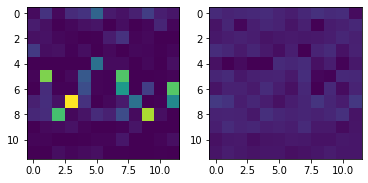

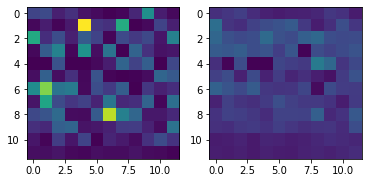

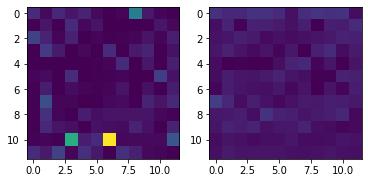

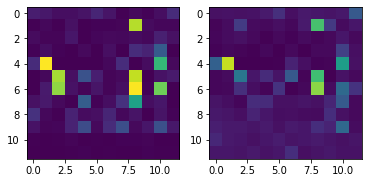

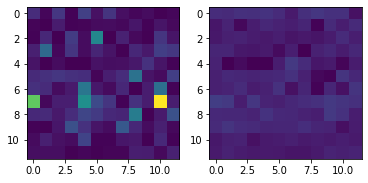

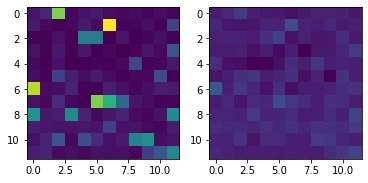

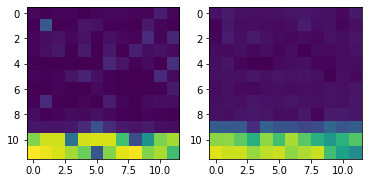

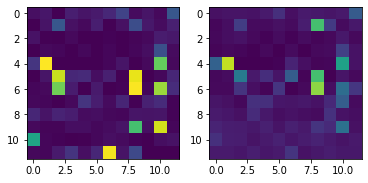

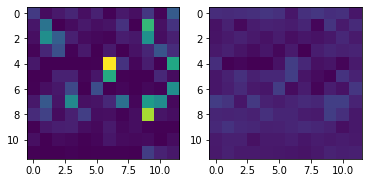

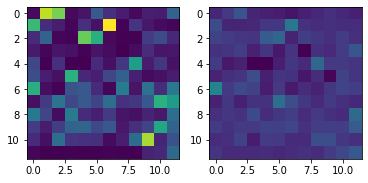

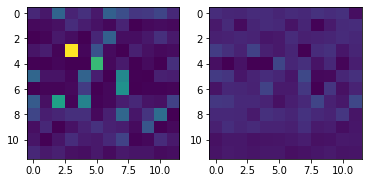

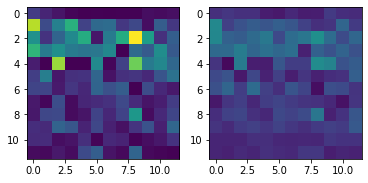

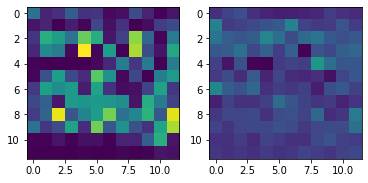

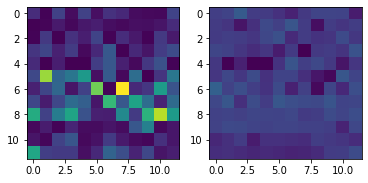

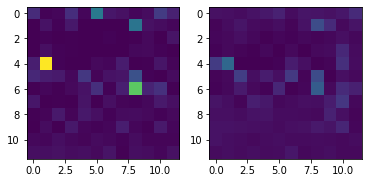

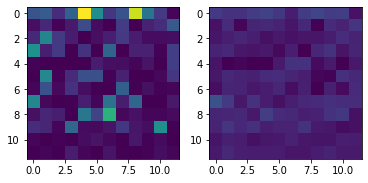

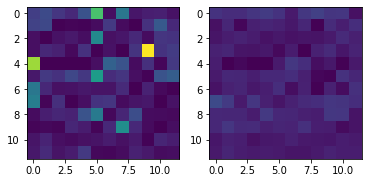

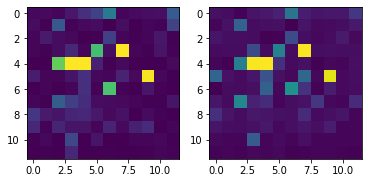

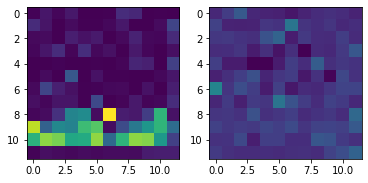

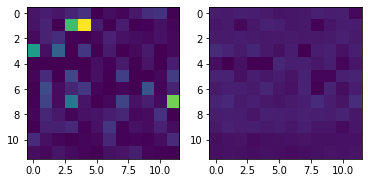

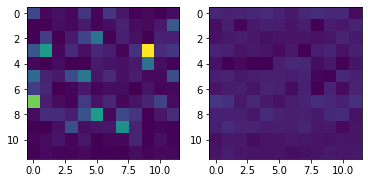

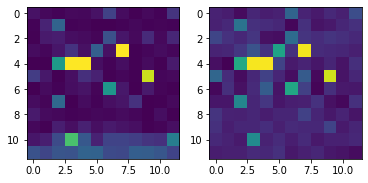

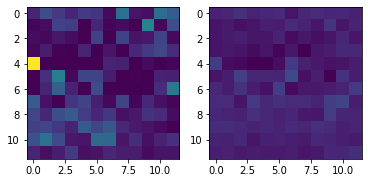

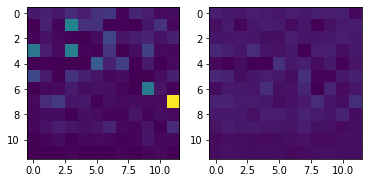

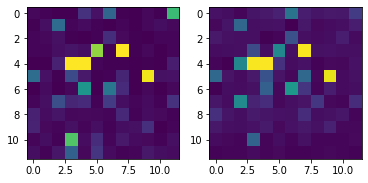

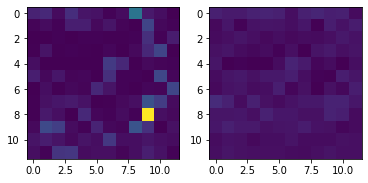

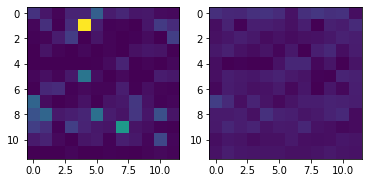

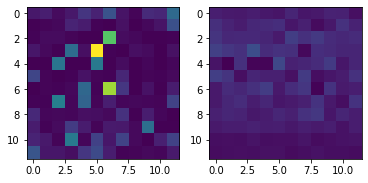

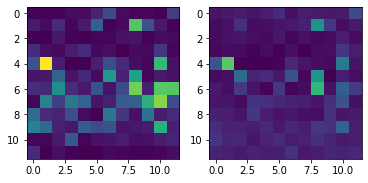

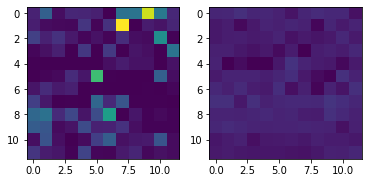

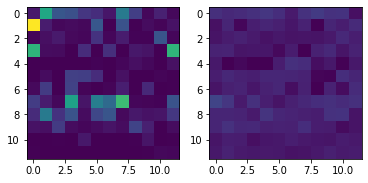

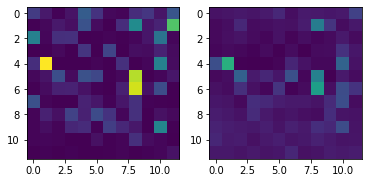

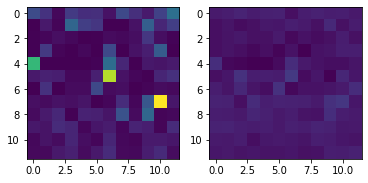

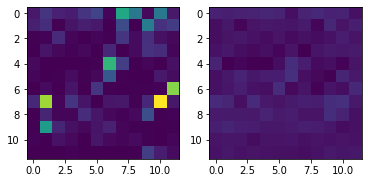

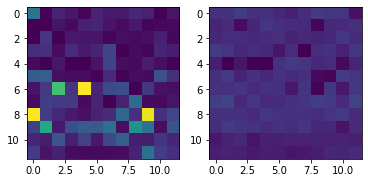

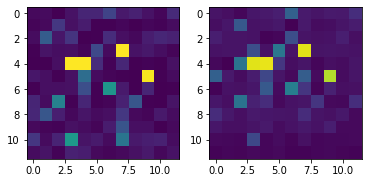

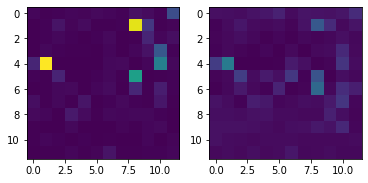

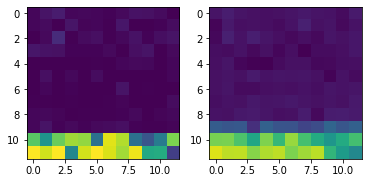

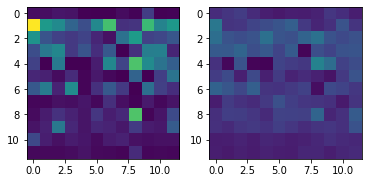

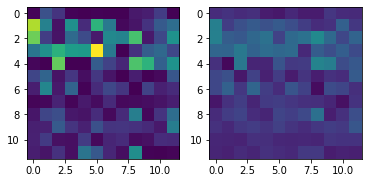

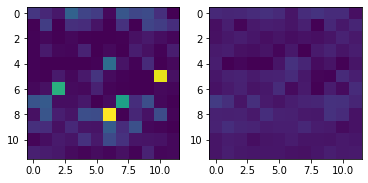

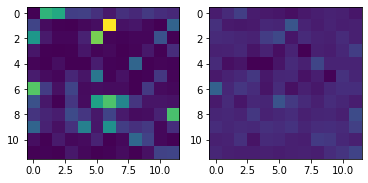

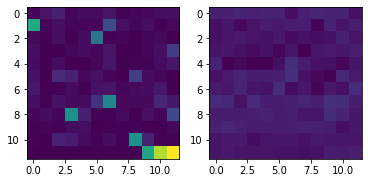

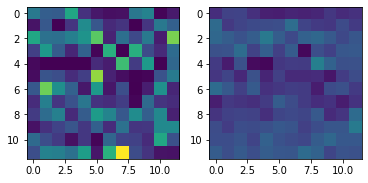

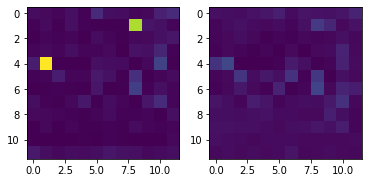

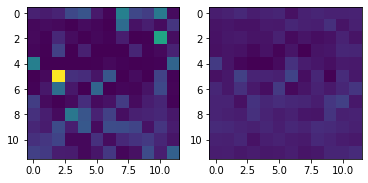

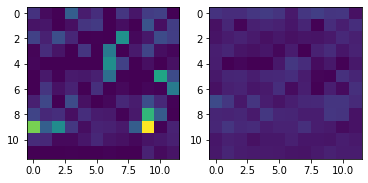

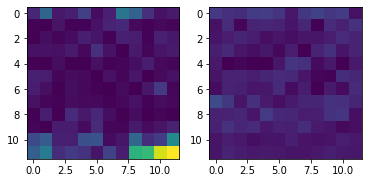

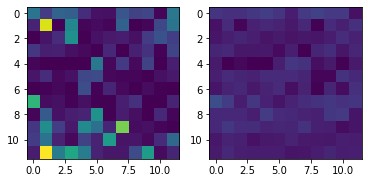

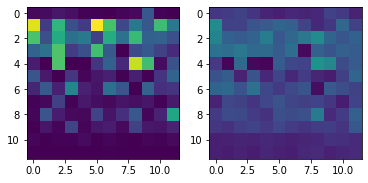

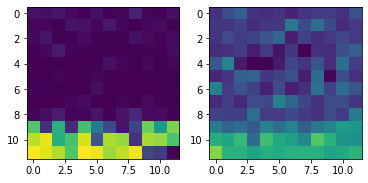

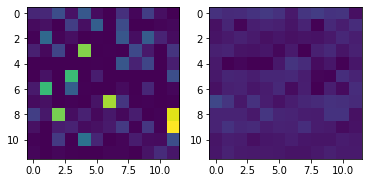

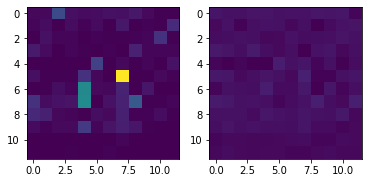

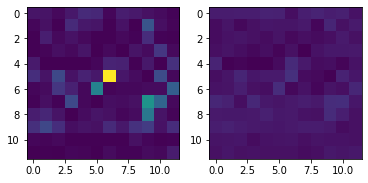

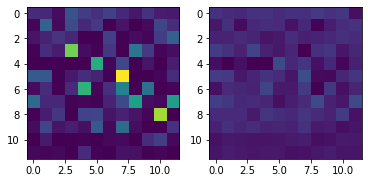

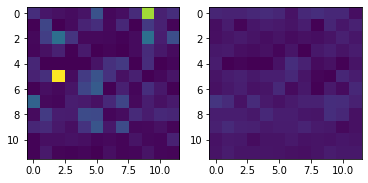

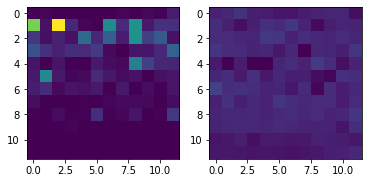

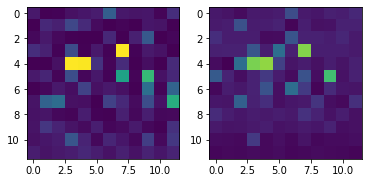

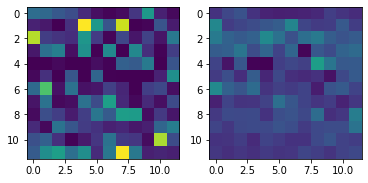

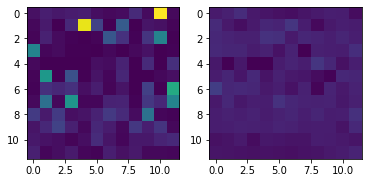

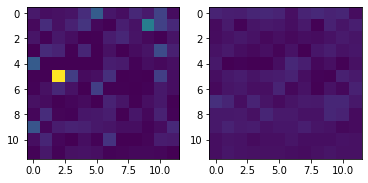

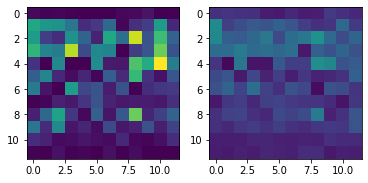

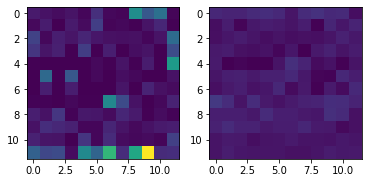

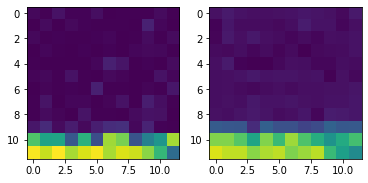

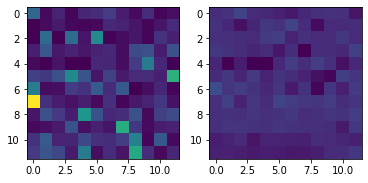

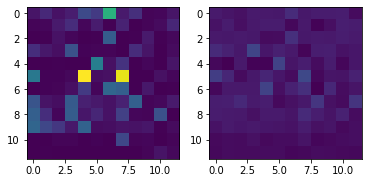

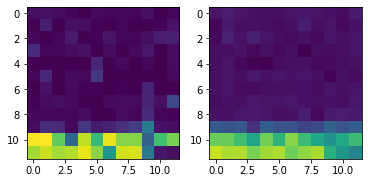

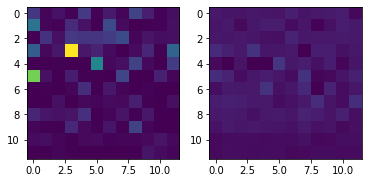

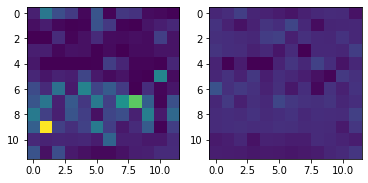

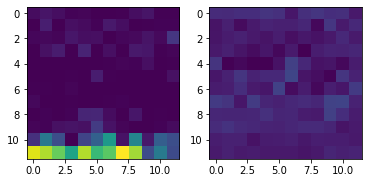

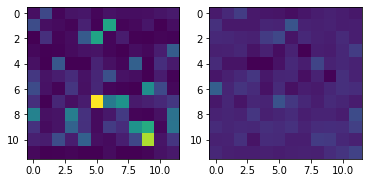

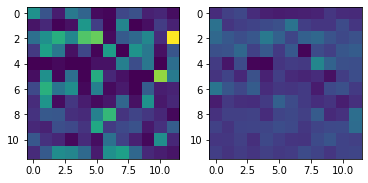

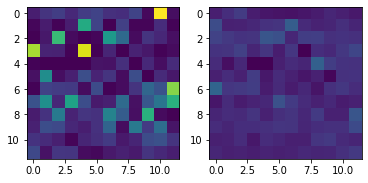

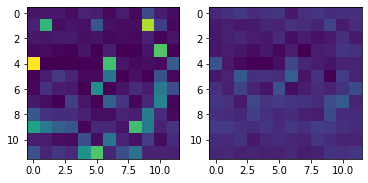

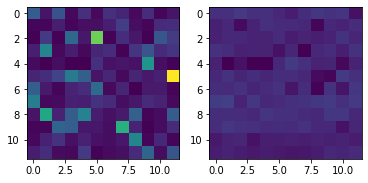

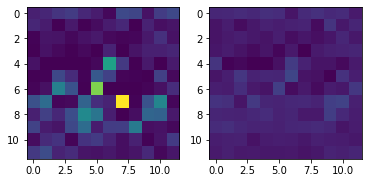

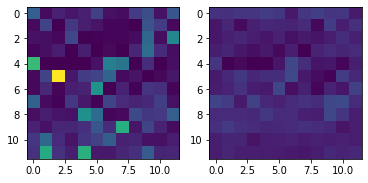

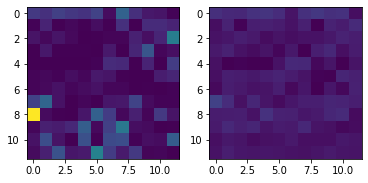

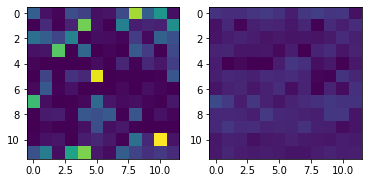

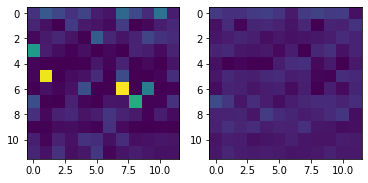

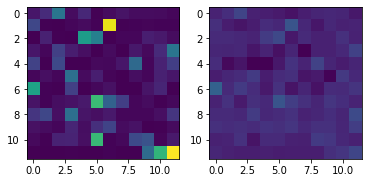

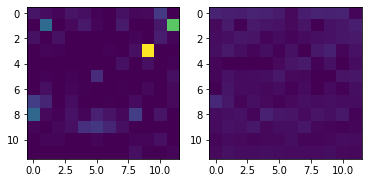

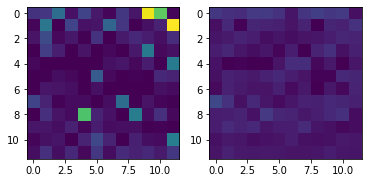

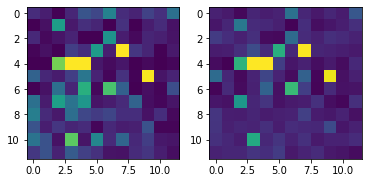

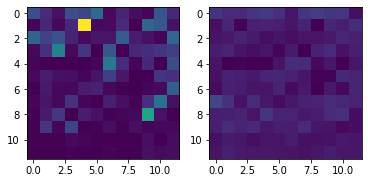

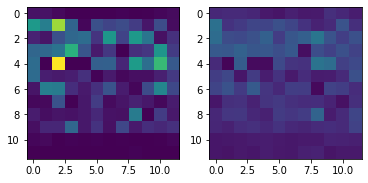

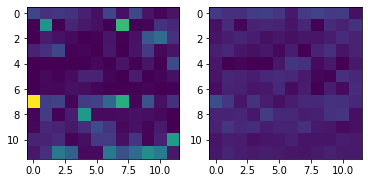

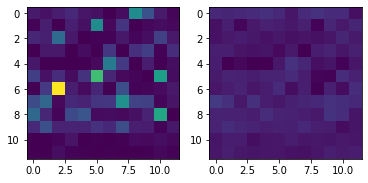

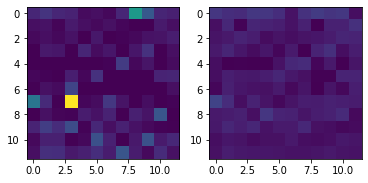

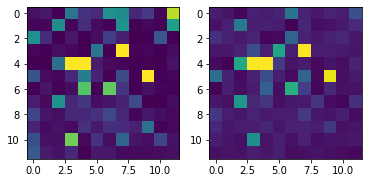

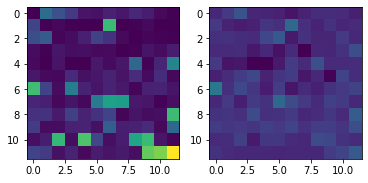

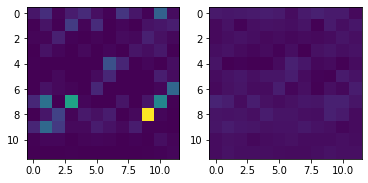

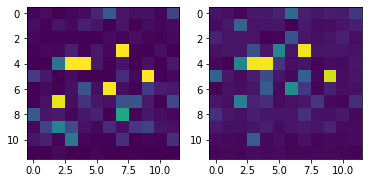

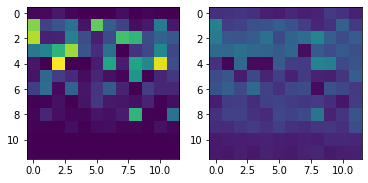

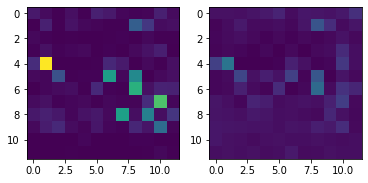

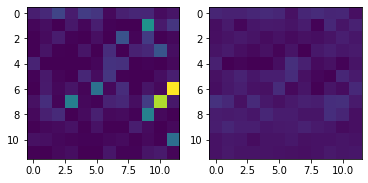

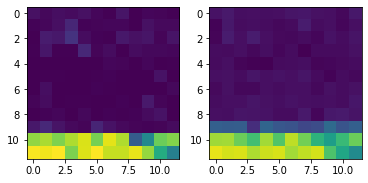

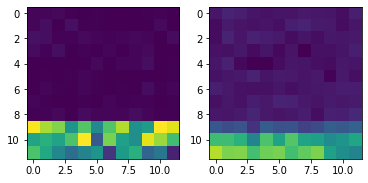

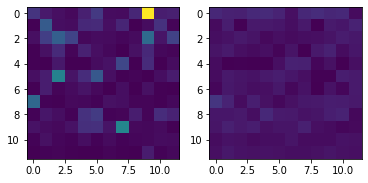

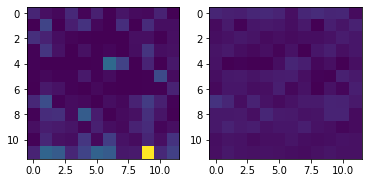

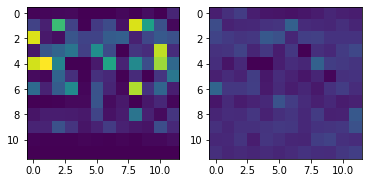

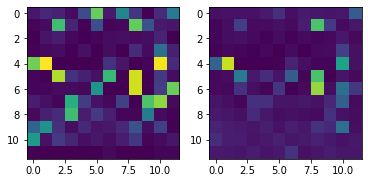

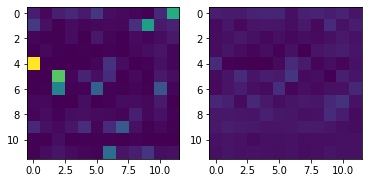

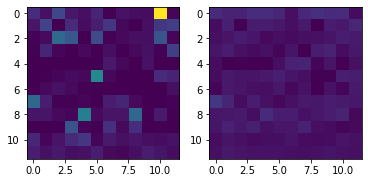

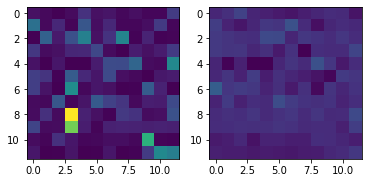

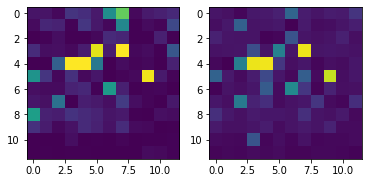

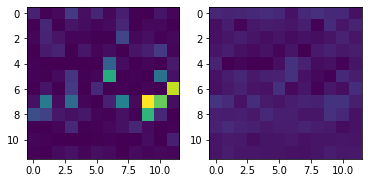

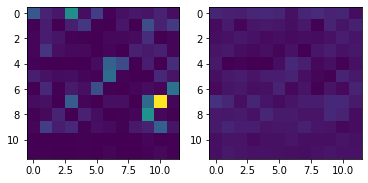

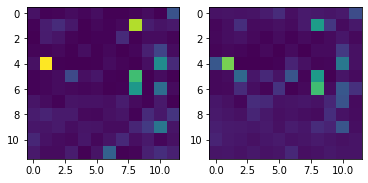

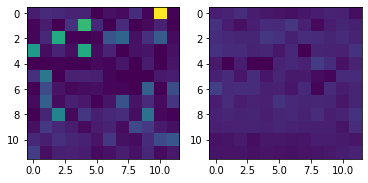

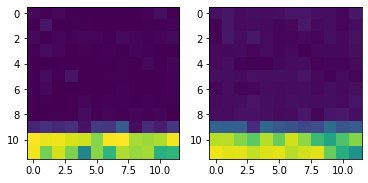

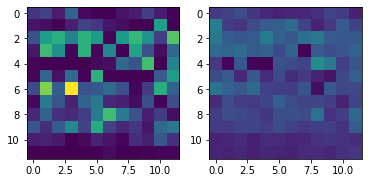

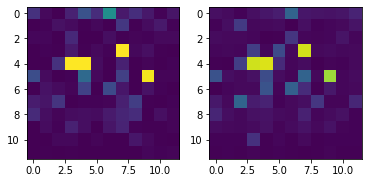

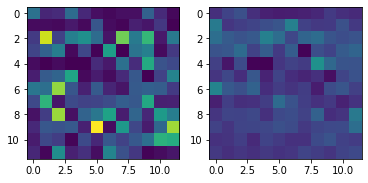

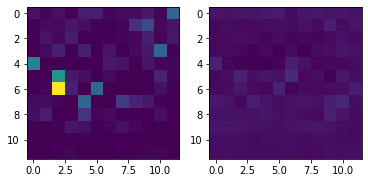

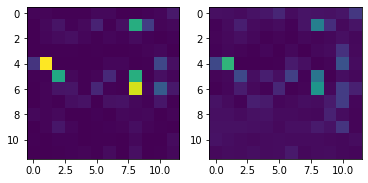

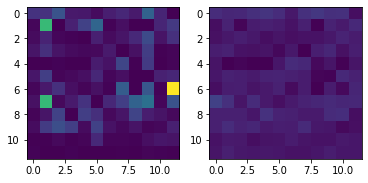

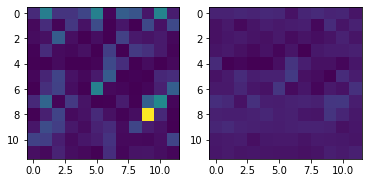

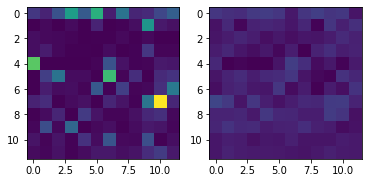

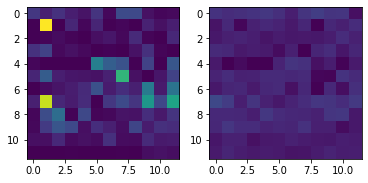

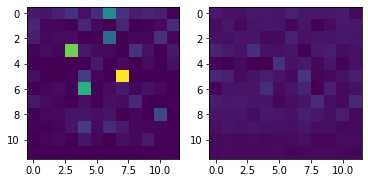

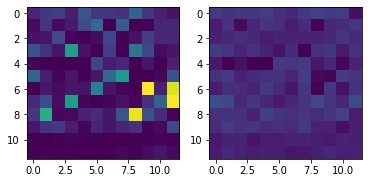

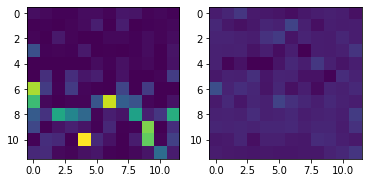

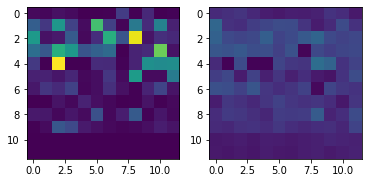

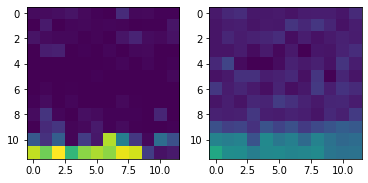

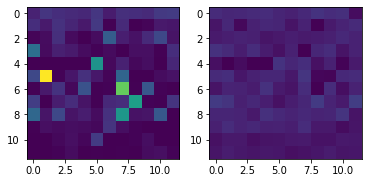

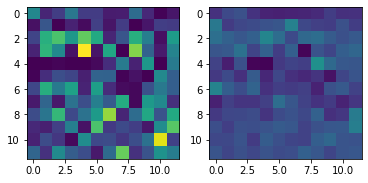

In [18]:
# Interesting results after 50 epochs, embedding size of 2 and 
# sample=3 idx=2 is interesting, very stable
# Interesting good combinations: (0, 10) nickname, 
# (9, 10) nickname
# (9, 7) cookies
# (10, 10) nickname
#(7, 2), (7, 6), (17, 7) (bottom filled!)
# Interesting bad combinations: (7, 3), (7, 5)

from IPython import display

for s in range(10):
    for b in range(32):
        sample_high_only(random_sample=False, deterministic_embedding=True, sample=s, batch_idx=b)
        #display.clear_output(wait=True)
        display.display(plt.gcf())



# Persistent attention coordinates (1, 4), (9, 8), (6, 10), (5, 345), (4, 68)
# Mildly persistent coordinates (8, 3), (7, 5)

###### EMBEDDING MAINFOLD #######


RuntimeError: size mismatch, m1: [1 x 10], m2: [2 x 100] at ../aten/src/TH/generic/THTensorMath.cpp:197

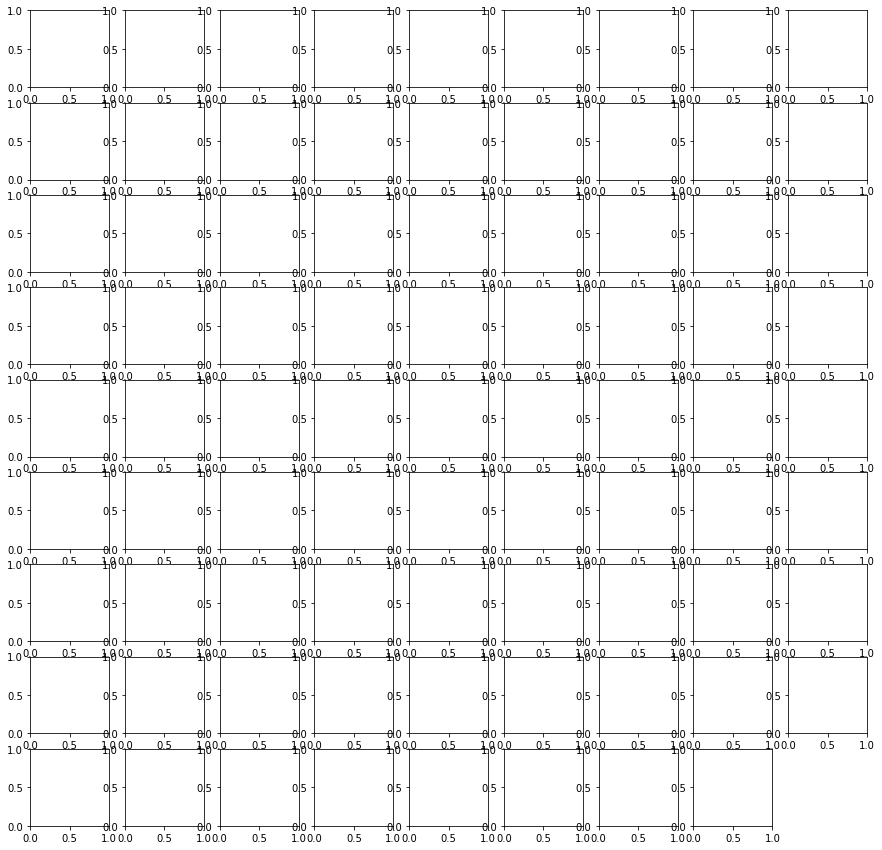

In [19]:
# mainfold visualization
L = 9
p = 1 # decimal place to do the rounding in the subplot title
e1 = torch.linspace(-5, 5, L).tolist()
e2 = torch.linspace(-5, 5, L).tolist()

fig, axs = plt.subplots(9, 9, figsize=(15,15))
plt.axis('off')

print('###### EMBEDDING MAINFOLD #######')
for idx, mu1 in enumerate(e1):
    for idy, mu2 in enumerate(e2):
        mu = torch.Tensor([mu1, mu2, 0, 0, 0, 0, 0, 0, 0, 0])
        recon_img = model.decode(mu)
        recon_img = recon_img.view(12, 12).detach().numpy()
        
        axs[idx, idy].imshow(recon_img, vmin=0, vmax=1)
        title = f'{round(mu1*10**p)/10**p}, {round(mu2*10**p)/10**p}'
        axs[idx, idy].title.set_text(title)
        axs[idx, idy].axis('off')

        